In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import concurrent
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from concurrent.futures import ThreadPoolExecutor
from IPython.core.display import display, HTML

warnings.filterwarnings("ignore")

In [2]:
# load dataset
use_columns = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "UniqueCarrier",
    "FlightNum",
    "TailNum",
    "CRSElapsedTime",
    "ArrDelay",
    "Origin",
    "Dest",
    "Distance",
    "TaxiIn",
    "TaxiOut",
    "Cancelled",
    "Diverted",
]

df = pd.read_csv("datasets/airline_arrival_delay/2007_light.csv", dtype={
    "Month": str,
    "DayofMonth": str,
    "DayOfWeek": str,
    "DepTime": str,
    "CRSDepTime": str,
    "CRSArrTime": str,
    "FlightNum": str,
    "Diverted": str
}, usecols=use_columns)

def add_prefix(columns, prefix, additional_text=""):
    new_columns = []
    
    for col in columns:
        transform = ''.join([e.capitalize() for e in col.split('_')])
        
        if prefix.lower() == col.lower():
            new_columns.append(f"{prefix}{additional_text}")
        else:
            new_columns.append(f"{prefix}{additional_text}{transform}")
            
    return new_columns

df_carriers = pd.read_csv("datasets/airline_arrival_delay/carriers.csv")
df_carriers.columns = add_prefix(df_carriers.columns, "Carrier")

df_planes = pd.read_csv("datasets/airline_arrival_delay/plane-data.csv")
df_planes.columns = add_prefix(df_planes.columns, "Plane")

df_airports_from = pd.read_csv("datasets/airline_arrival_delay/airports.csv")
df_airports_from.columns = add_prefix(df_airports_from.columns, "Airport", "From")

df_airports_to = pd.read_csv("datasets/airline_arrival_delay/airports.csv")
df_airports_to.columns = add_prefix(df_airports_to.columns, "Airport", "To")

In [3]:
df = pd.merge(df, df_carriers, left_on="UniqueCarrier", right_on="CarrierCode", how="inner")
df = pd.merge(df, df_planes, left_on="TailNum", right_on="PlaneTailnum", how="inner")
df = pd.merge(df, df_airports_from, left_on="Origin", right_on="AirportFromIata", how="inner")
df = pd.merge(df, df_airports_to, left_on="Dest", right_on="AirportToIata", how="inner")

In [4]:
del df_carriers, df_planes, df_airports_from, df_airports_to

In [5]:
# I only use 3.000.000 records due to computer capacity
df = df.sample(n=3000000)

## All columns and their description

2. Month: ~~ 1-12
3. DayofMonth: ~~ 1-31
4. DayOfWeek: ~~ 1 (Monday) - 7 (Sunday)
5. CRSDepTime: ~~ scheduled departure time (local, hhmm)
6. CRSArrTime: ~~ scheduled arrival time (local, hhmm)
7. UniqueCarrier: ~~ unique carrier code
8. FlightNum: ~~ flight number
9. TailNum: ~~ plane tail number
10. CRSElapsedTime: ~~ in minutes ------ __have negative number__
11. ArrDelay: ~~ arrival delay, in minutes
12. Origin: ~~ origin IATA airport code
13. Dest: ~~ destination IATA airport code
14. Distance: ~~ in miles
15. TaxiIn: ~~ taxi in time, in minutes
16. TaxiOut: ~~ taxi out time in minutes
17. Cancelled: ~~ was the flight cancelled?
18. Diverted: ~~ 1 = yes, 0 = no

## Exploratory Data Analysis

In [6]:
# set labels for dataset
df["IsLate"] = df["ArrDelay"].apply(lambda x: x > 30)
# filter out cancelled flights
df = df[df["Cancelled"] == False]

# drop unnecessary columns after merging
df = df.drop([
    "UniqueCarrier",
    "CarrierCode",
    "TailNum",
    "PlaneTailnum",
    "Origin",
    "AirportFromIata",
    "Dest",
    "AirportToIata",
    "ArrDelay",
    "Cancelled",
    "AirportFromCountry",
    "AirportToCountry",
], axis=1)

In [9]:
# after filtering unnecessary columns, we now have only 30 features, 8 of them are numerical
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2981614 entries, 3086526 to 3552769
Data columns (total 31 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Month               object 
 1   DayofMonth          object 
 2   DayOfWeek           object 
 3   CRSDepTime          object 
 4   CRSArrTime          object 
 5   FlightNum           object 
 6   CRSElapsedTime      float64
 7   Distance            int64  
 8   TaxiIn              int64  
 9   TaxiOut             int64  
 10  Diverted            object 
 11  CarrierDescription  object 
 12  PlaneType           object 
 13  PlaneManufacturer   object 
 14  PlaneIssueDate      object 
 15  PlaneModel          object 
 16  PlaneStatus         object 
 17  PlaneAircraftType   object 
 18  PlaneEngineType     object 
 19  PlaneYear           object 
 20  AirportFrom         object 
 21  AirportFromCity     object 
 22  AirportFromState    object 
 23  AirportFromLat      float64
 24  AirportFromLong   

In [10]:
df.describe()

,CRSElapsedTime,Distance,TaxiIn,TaxiOut,AirportFromLat,AirportFromLong,AirportToLat,AirportToLong
count,2.981613e+06,2.981614e+06,2.981614e+06,2.981614e+06,2.981614e+06,2.981614e+06,2.981614e+06,2.981614e+06
mean,1.289838e+02,7.355882e+02,6.805268e+00,1.666029e+01,3.674047e+01,-9.554353e+01,3.674145e+01,-9.553345e+01
std,7.154833e+01,5.715417e+02,5.084516e+00,1.178032e+01,5.753031e+00,1.836816e+01,5.754029e+00,1.837542e+01
min,1.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.770189e+01,-1.766460e+02,1.770189e+01,-1.766460e+02
25%,7.800000e+01,3.250000e+02,4.000000e+00,1.000000e+01,3.343417e+01,-1.119778e+02,3.343417e+01,-1.119778e+02
50%,1.100000e+02,5.870000e+02,6.000000e+00,1.400000e+01,3.750517e+01,-8.997667e+01,3.750517e+01,-8.997667e+01
75%,1.600000e+02,9.640000e+02,8.000000e+00,1.900000e+01,4.077724e+01,-8.144247e+01,4.077724e+01,-8.131603e+01
max,6.600000e+02,4.962000e+03,5.450000e+02,4.030000e+02,7.128545e+01,-6.479856e+01,7.128545e+01,-6.479856e+01


#### Exploration

__CrsElapsedTime:__ Negative numbers means flying back in time zone (bay ngược múi giờ) (but in another dataset)

In [11]:
df.describe(include="O").T

,count,unique,top,freq
Month,2981614,12,8,266810
DayofMonth,2981614,31,12,100178
DayOfWeek,2981614,7,1,445815
CRSDepTime,2981614,1181,600,52620
CRSArrTime,2981614,1386,1930,10880
FlightNum,2981614,7562,16,2229
Diverted,2981614,2,0,2974654
CarrierDescription,2981614,19,Southwest Airlines Co.,467902
PlaneType,2827885,5,Corporation,2808553
PlaneManufacturer,2827885,35,BOEING,1166087


In [12]:
df.head(5).T

,3086526,572249,4019566,4160076,4018162
Month,11,1,3,9,1
DayofMonth,2,14,8,25,16
DayOfWeek,5,7,4,2,2
CRSDepTime,1620,1830,1145,2210,1650
CRSArrTime,1725,2104,1437,2359,1810
FlightNum,1482,943,2468,2696,2434
CRSElapsedTime,65,274,112,109,80
Distance,247,1745,694,529,304
TaxiIn,14,10,7,7,15
TaxiOut,17,9,11,35,10


In [13]:
print(f"Total rows: {len(df)}")

Total rows: 2981614


### Check missing values

In [14]:
# list all columns with their total missing values
nan_summary = df.isnull().sum()
nan_summary

Month                      0
DayofMonth                 0
DayOfWeek                  0
CRSDepTime                 0
CRSArrTime                 0
FlightNum                  0
CRSElapsedTime             1
Distance                   0
TaxiIn                     0
TaxiOut                    0
Diverted                   0
CarrierDescription         0
PlaneType             153729
PlaneManufacturer     153729
PlaneIssueDate        153729
PlaneModel            153729
PlaneStatus           153729
PlaneAircraftType     153729
PlaneEngineType       153729
PlaneYear             153729
AirportFrom                0
AirportFromCity         2155
AirportFromState        2155
AirportFromLat             0
AirportFromLong            0
AirportTo                  0
AirportToCity           2147
AirportToState          2147
AirportToLat               0
AirportToLong              0
IsLate                     0
dtype: int64

In [15]:
# the missing value only 5% which is not really significant => drop all missing value
df = df.dropna()

### Heatmap visualization

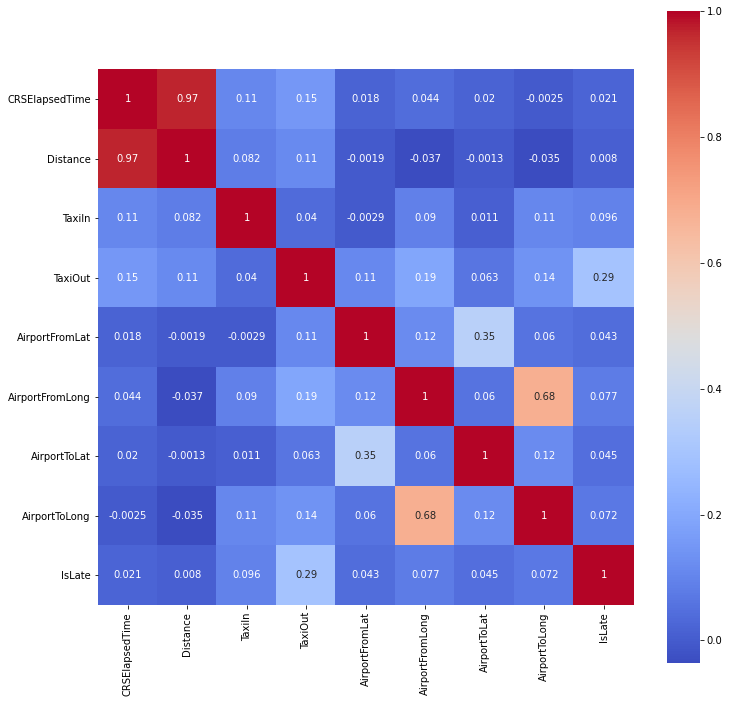

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, square=True, cmap="coolwarm", ax=ax);

# the scheduled time & actual time is strictly correlated -> should get the difference
# airtime & distance are also correlated with actual & schedule elapsed time

### Visualization numerical data based on IsLate label

<Figure size 720x504 with 0 Axes>

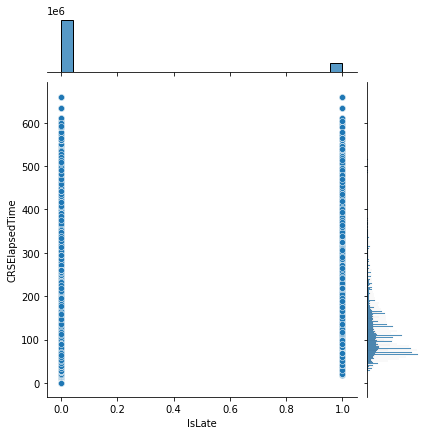

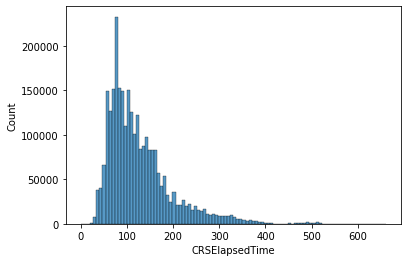

<Figure size 720x504 with 0 Axes>

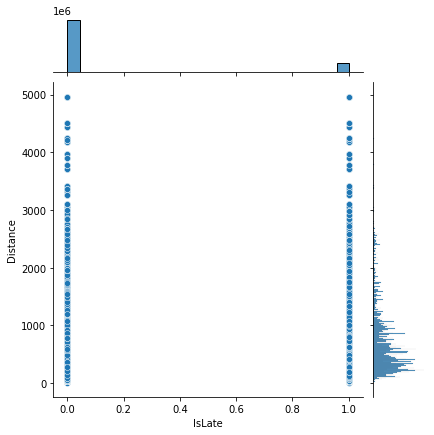

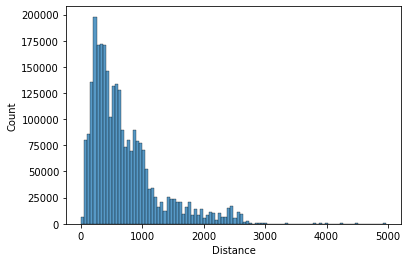

<Figure size 720x504 with 0 Axes>

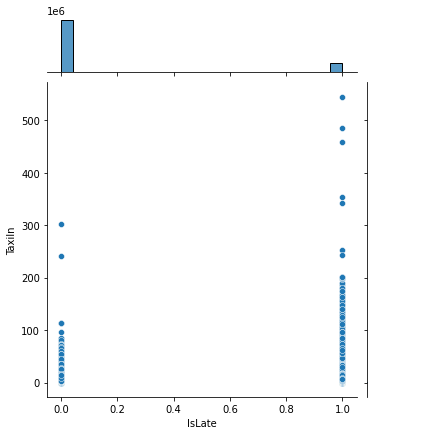

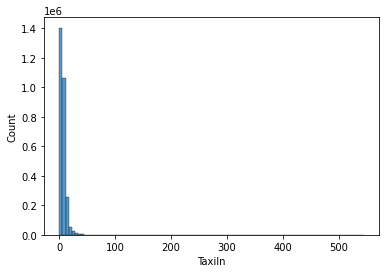

<Figure size 720x504 with 0 Axes>

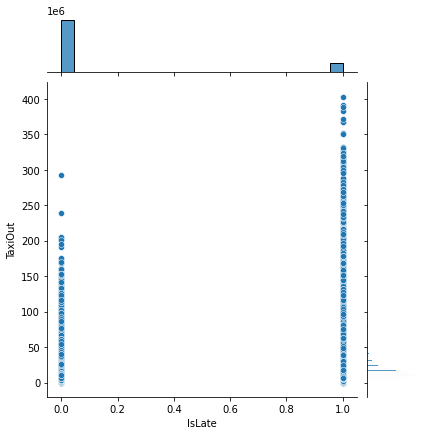

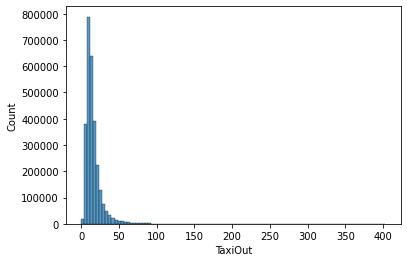

<Figure size 720x504 with 0 Axes>

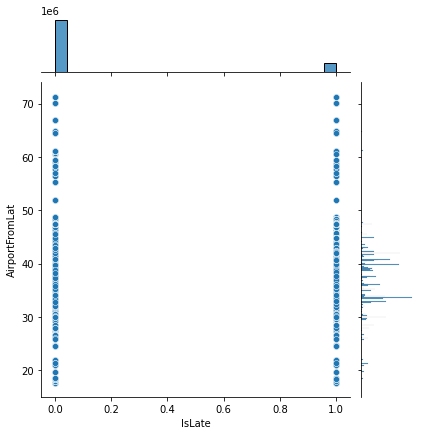

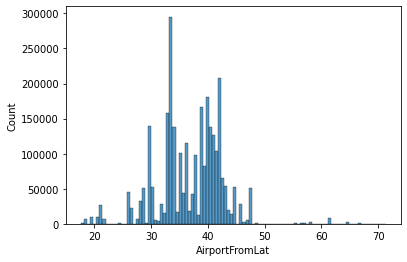

<Figure size 720x504 with 0 Axes>

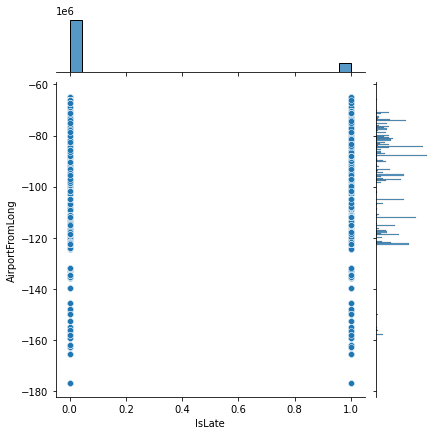

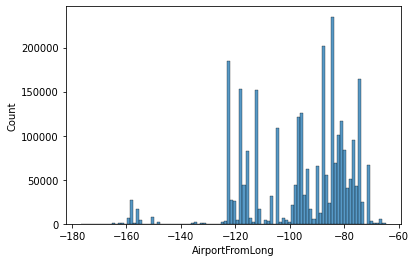

<Figure size 720x504 with 0 Axes>

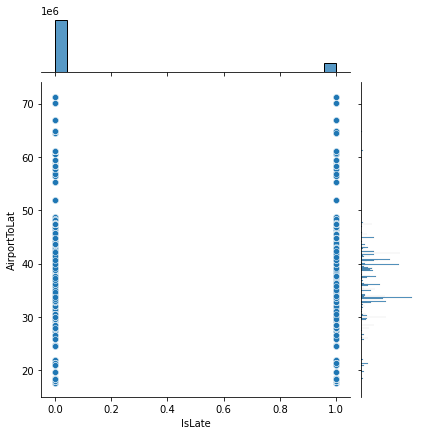

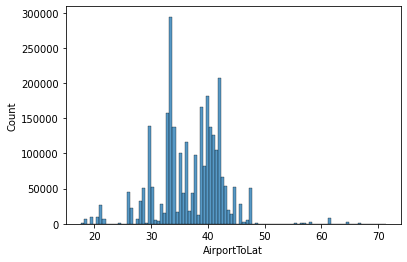

<Figure size 720x504 with 0 Axes>

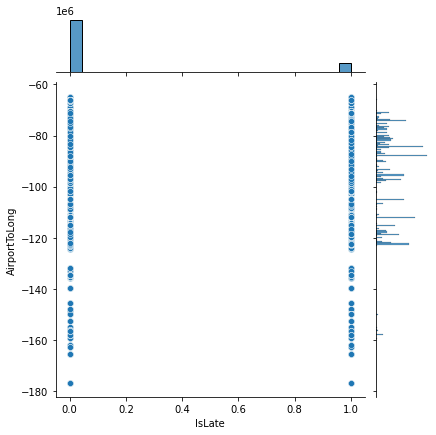

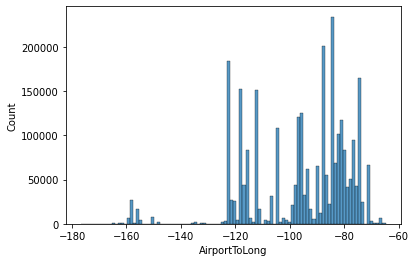

In [17]:
numerical_features = [
    "CRSElapsedTime",
    "Distance",
    "TaxiIn",
    "TaxiOut",
    "AirportFromLat",
    "AirportFromLong",
    "AirportToLat",
    "AirportToLong"
]

for column in numerical_features:
    plt.figure(figsize=(10, 7))
    display(HTML(f"<h4>{column}</h4>"))
    
    sns.jointplot(data=df, x="IsLate", y=column);
    plt.show()
    
    sns.histplot(df[column], bins=100);
    plt.show()

# Via data population, I can see that only the features like TaxiIn, Taxiout affect the lateness directly
# Significantly, distance doesn't show any relation with IsLate

### Visualization categorical data based on IsLate label

In [18]:
def split_hour(date):
    return date[:2]

def add_prefix_to_date(day):
    if len(day) == 1:
        return f"0{day}"
    
    return day

def add_prefix_to_time(time):
    return time.rjust(4, "0")

# df = df_backup.copy()
df["CRSDepTime"] = df["CRSDepTime"].apply(add_prefix_to_time)
df["CRSArrTime"] = df["CRSArrTime"].apply(add_prefix_to_time)
df["CRSDepTime_Hour"] = df["CRSDepTime"].apply(split_hour)
df["CRSArrTime_Hour"] = df["CRSArrTime"].apply(split_hour)
df["Month"] = df["Month"].apply(add_prefix_to_date)
df["DayofMonth"] = df["DayofMonth"].apply(add_prefix_to_date)
df["Diverted"] = df["Diverted"].map({"0": "Non-diverted", "1": "Diverted"})
df["PlaneIssueYear"] = df["PlaneIssueDate"].apply(lambda e: e.split("/")[-1])

# diverted is all NaN column, so I would drop this feature
df = df.drop(["CRSDepTime", "CRSArrTime", "PlaneIssueDate", "Diverted"], axis=1)

In [19]:
def calculate_categorical_percentage(df, column):
    visualize = df.groupby(column)["IsLate"].value_counts().sort_index().to_frame()
    visualize["TotalFlights"] = df.groupby(column)["IsLate"].value_counts().values
    visualize = visualize.drop(["IsLate"], axis=1).sort_index().reset_index()
    
    column_values1 = visualize[visualize["IsLate"] == True][column].unique()
    column_values2 = visualize[visualize["IsLate"] == False][column].unique()
    
    column_values = list(set(column_values1) & set(column_values2))
    column_values.sort()
    
    total_flights = visualize[visualize[column].isin(column_values)].groupby(column)["TotalFlights"].sum()
    is_late = visualize[(visualize["IsLate"] == True) & (visualize[column].isin(column_values))]["TotalFlights"]
    is_not_late = visualize[(visualize["IsLate"] == False) & (visualize[column].isin(column_values))]["TotalFlights"]

    is_late_percentage = [value / total_flights[i] * 100 for i, value in enumerate(is_late)]
    is_not_late_percentage = [value / total_flights[i] * 100 for i, value in enumerate(is_not_late)]
    
    return visualize, column_values, is_late_percentage, is_not_late_percentage

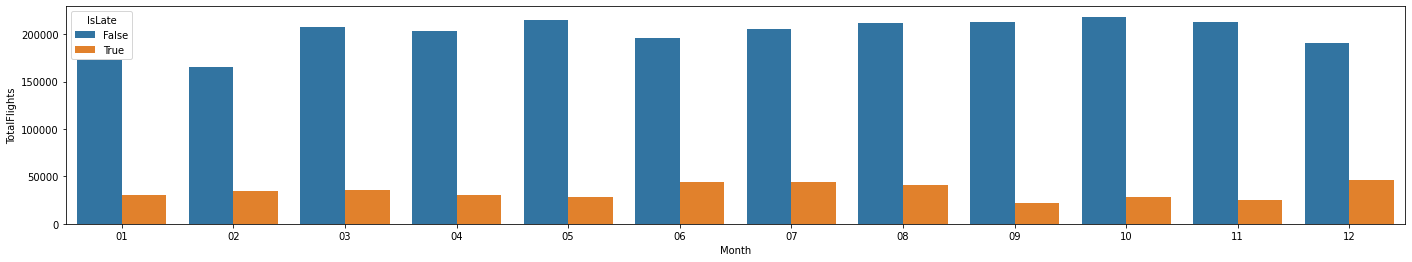

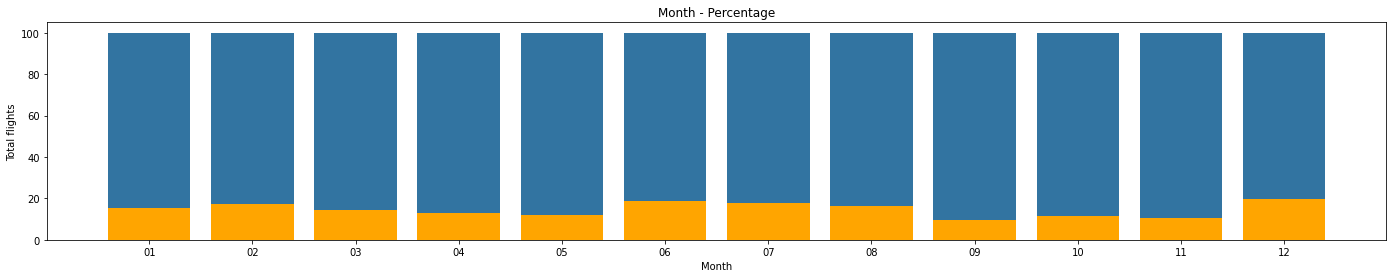

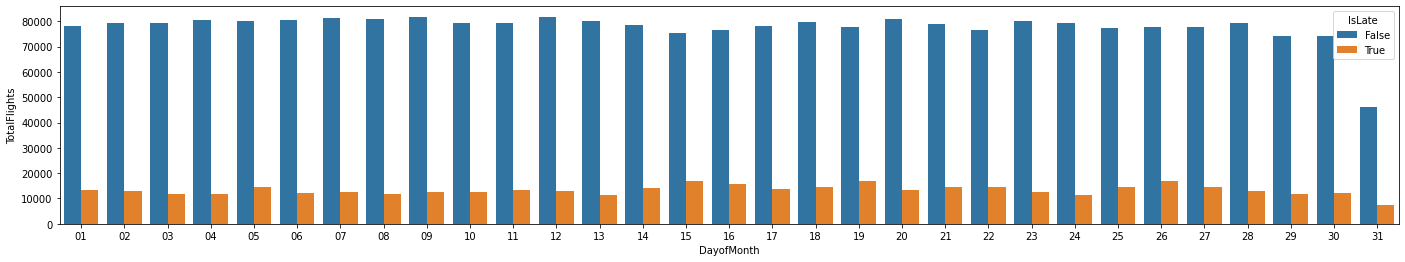

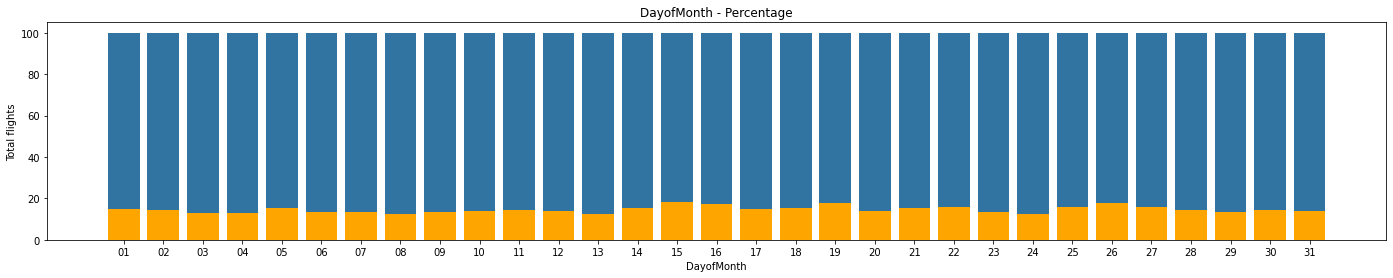

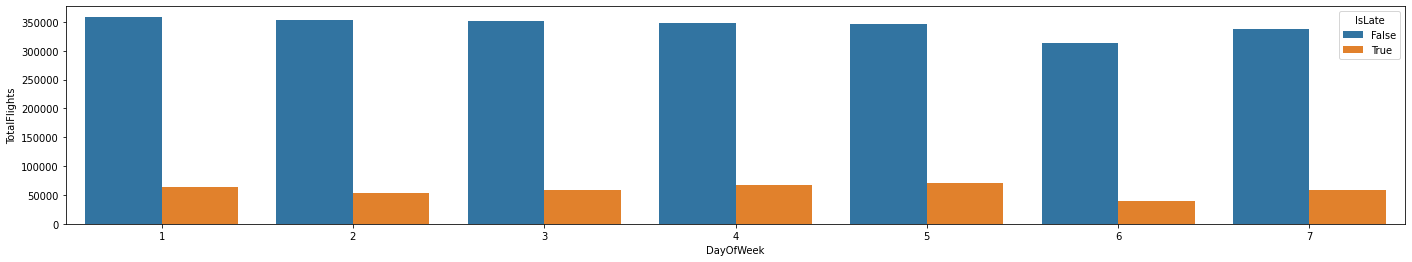

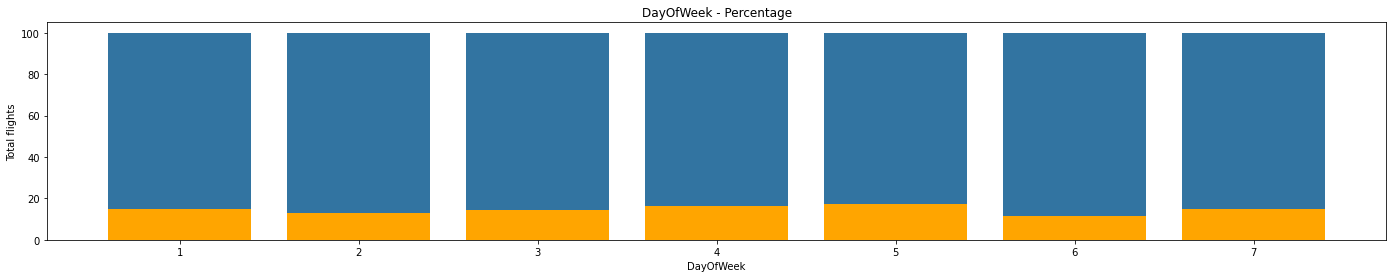

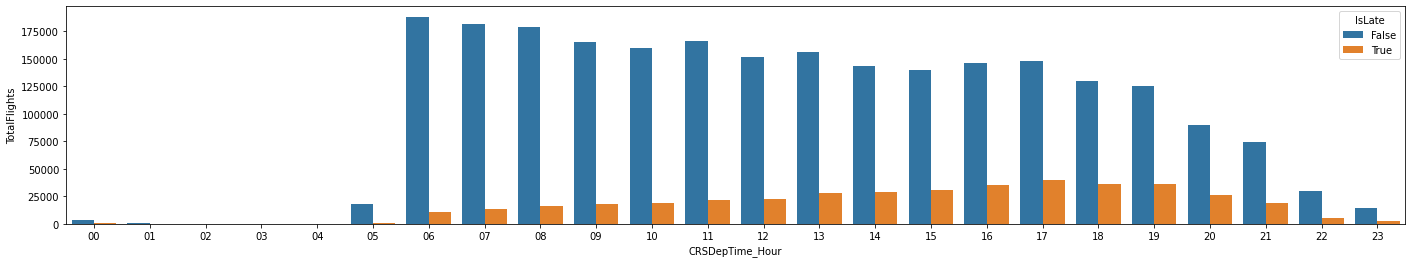

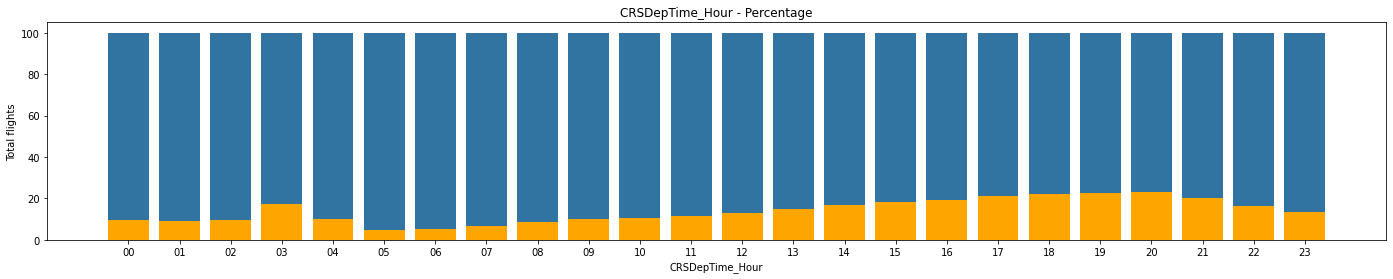

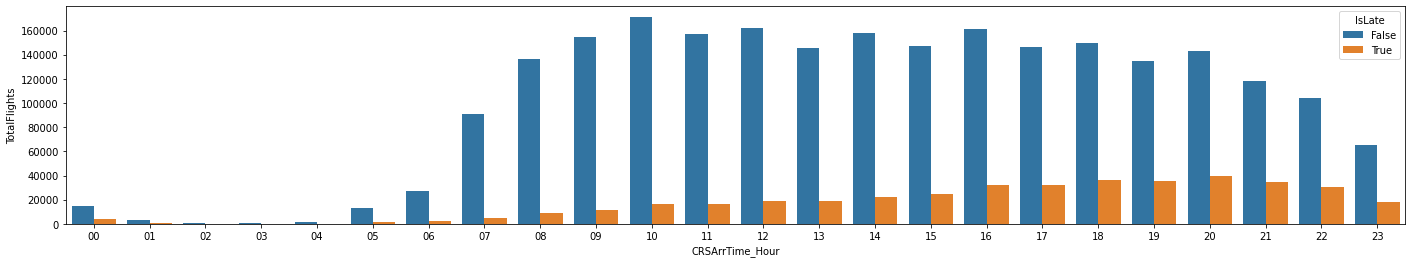

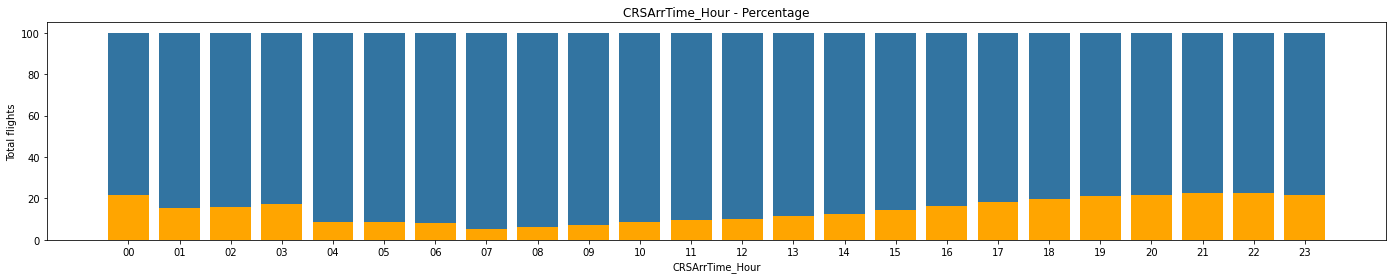

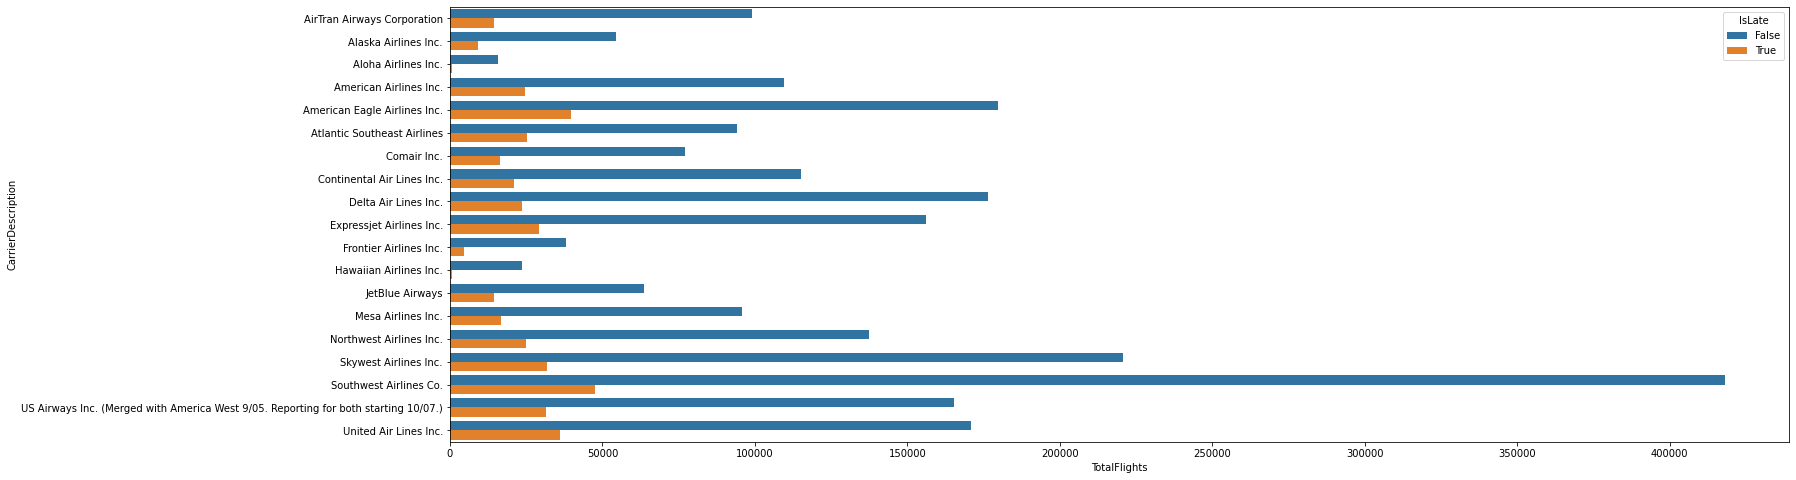

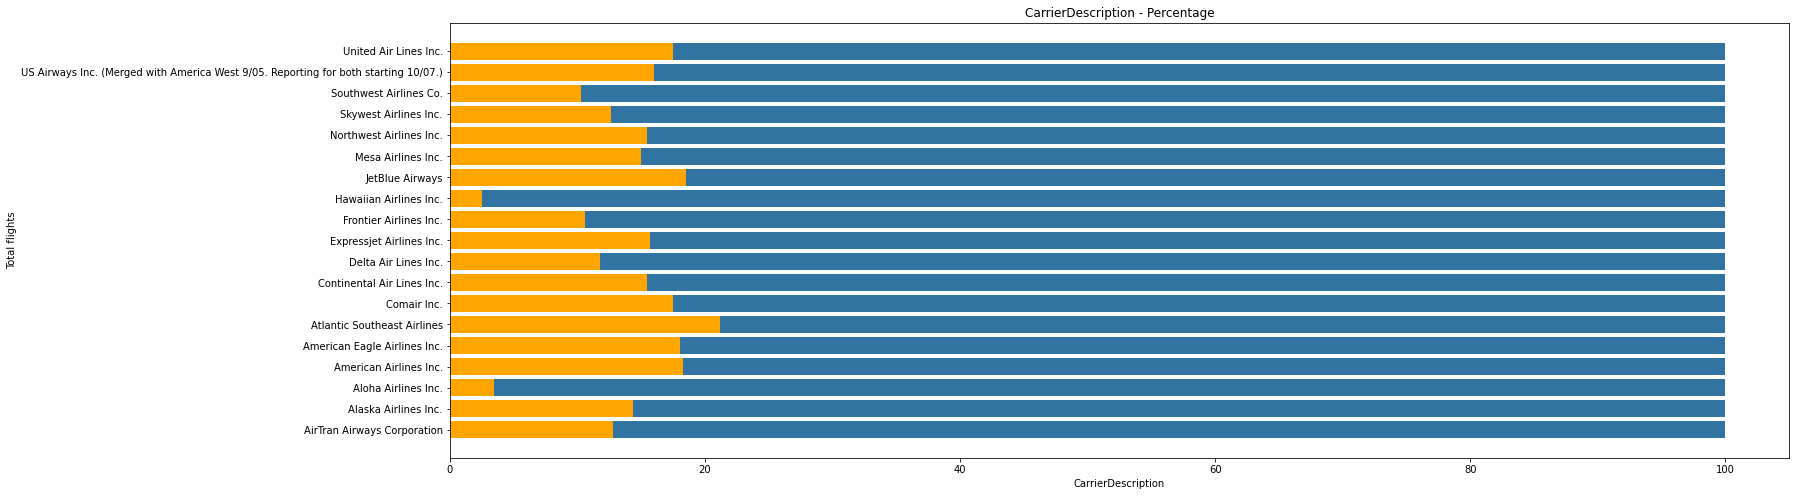

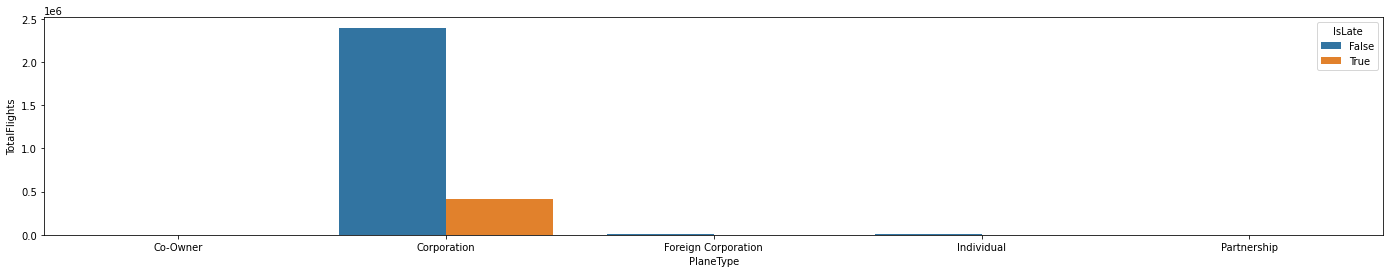

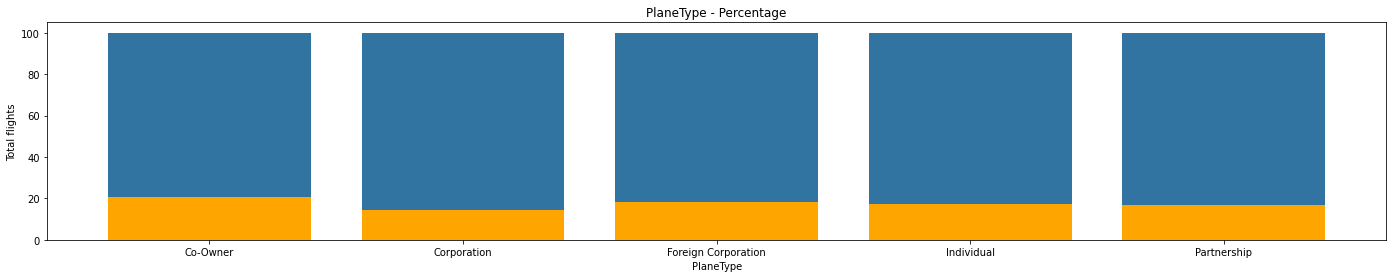

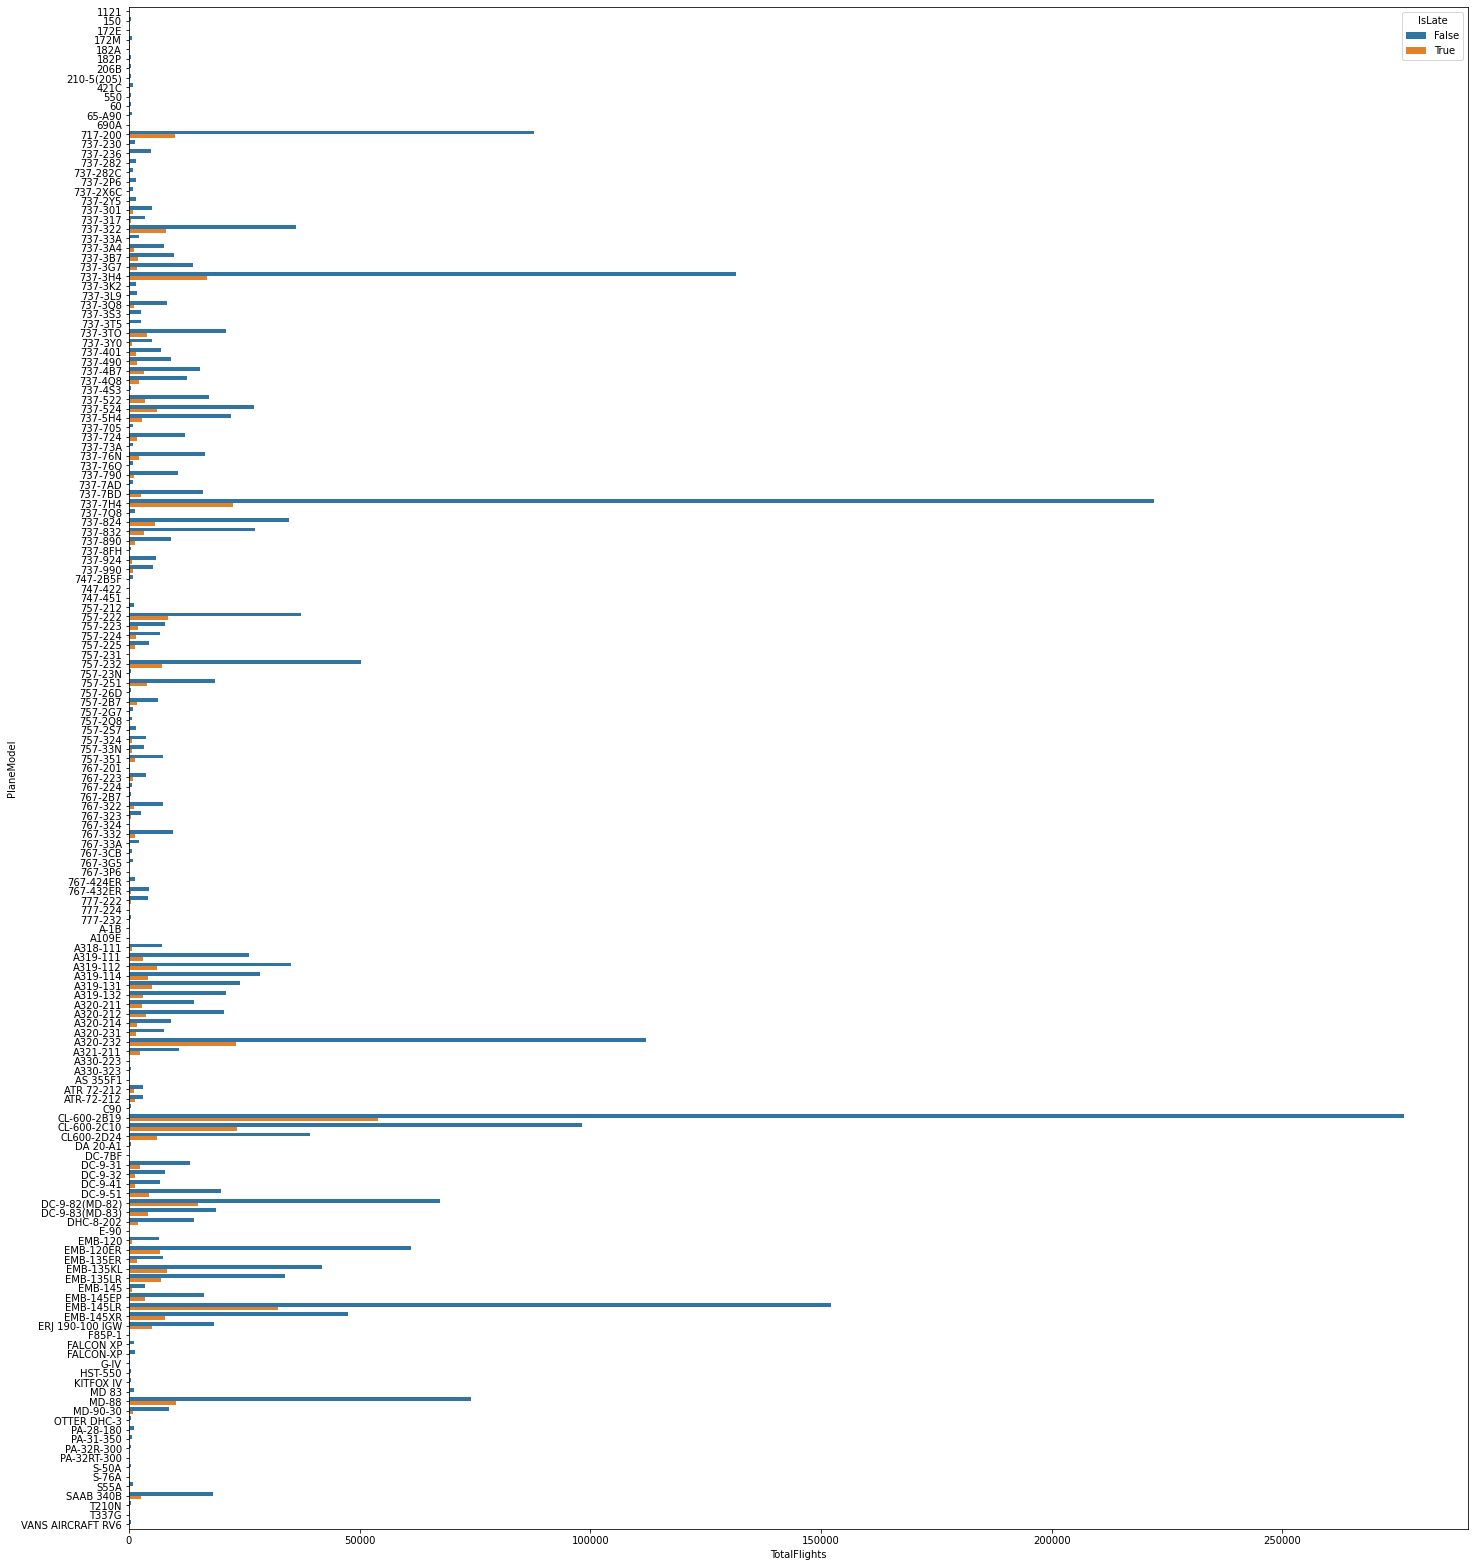

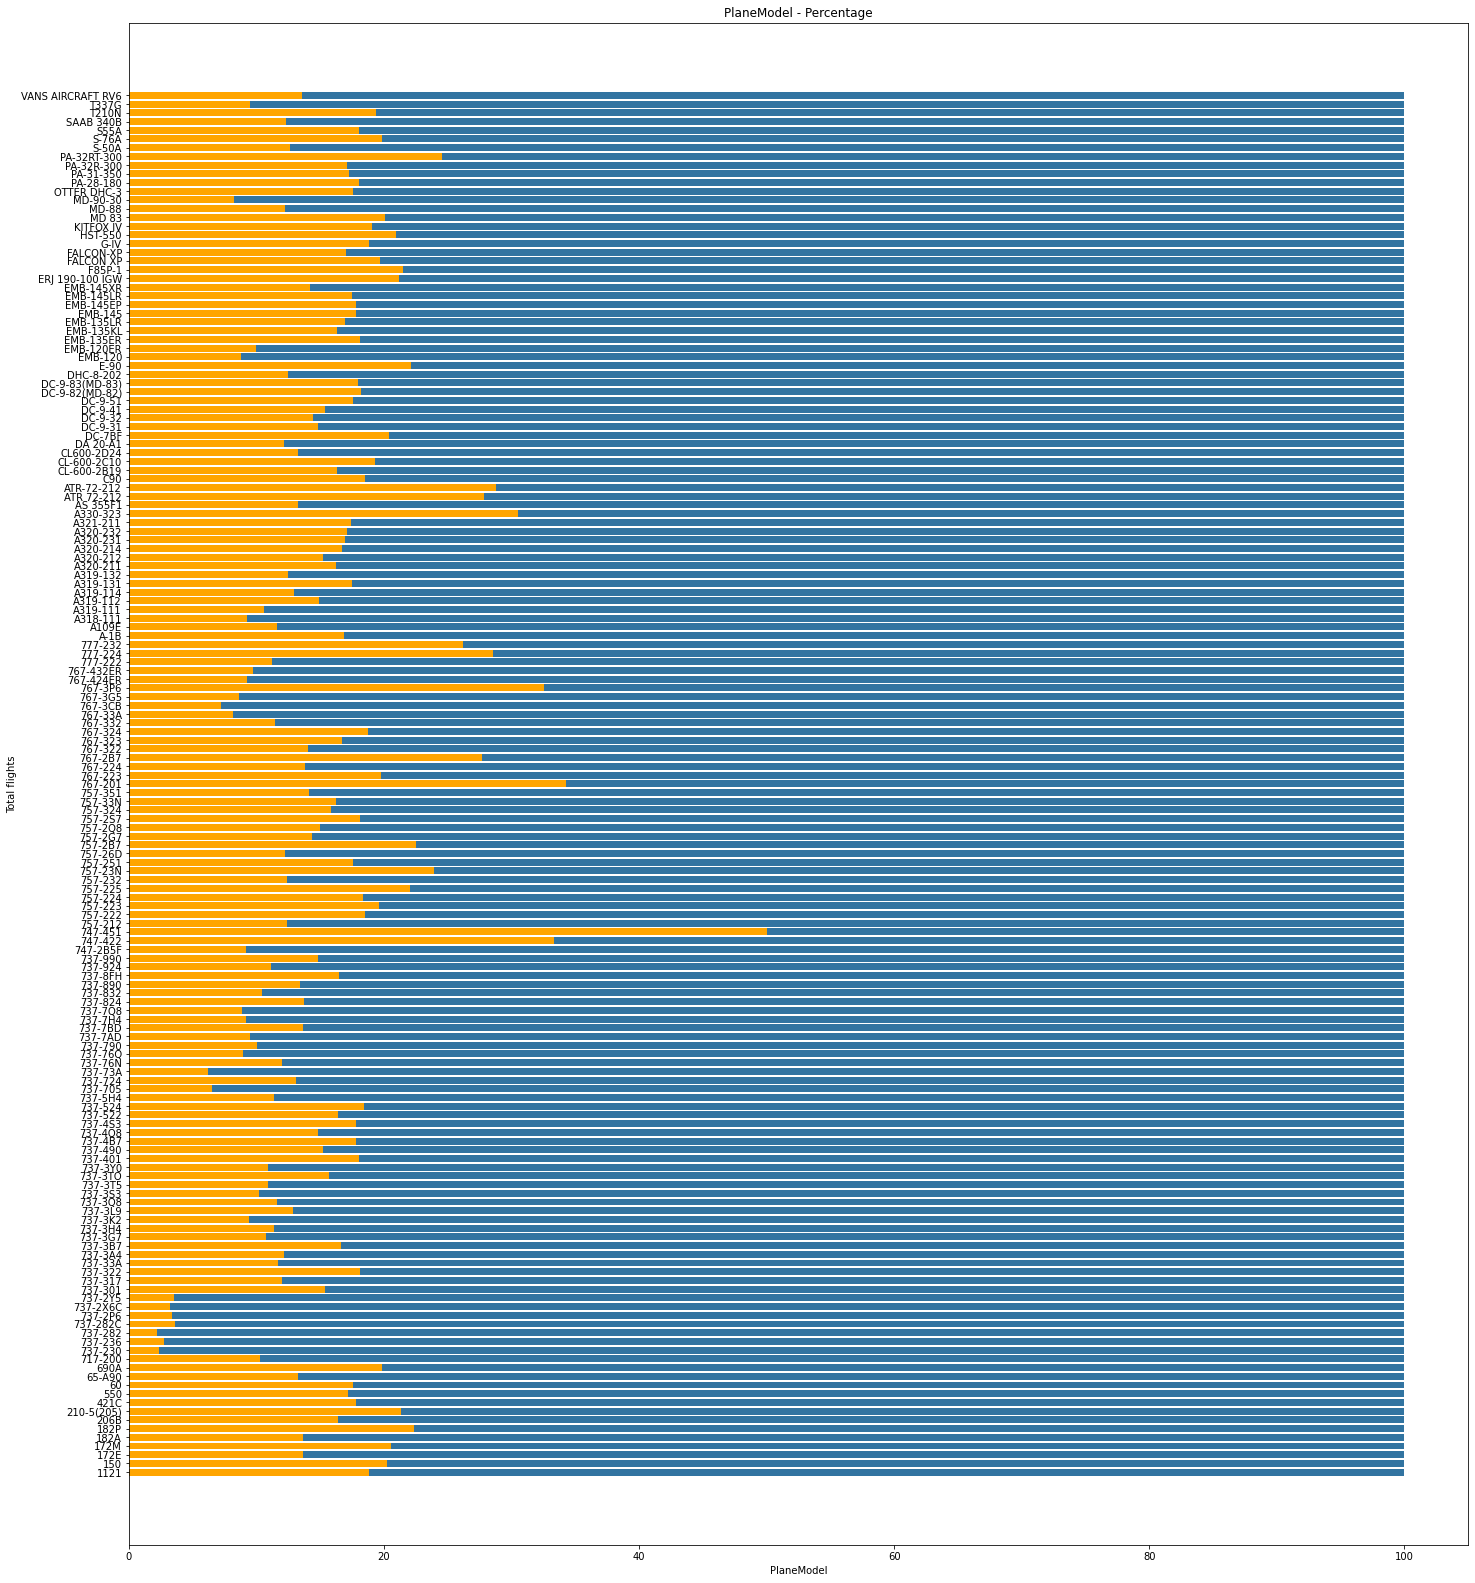

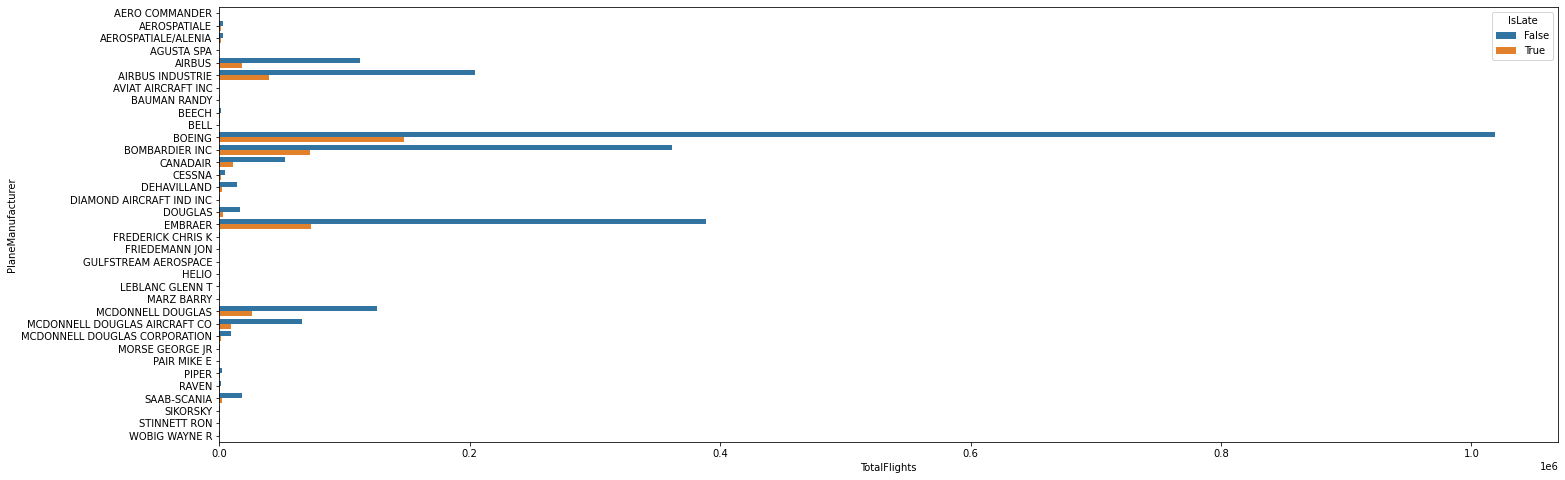

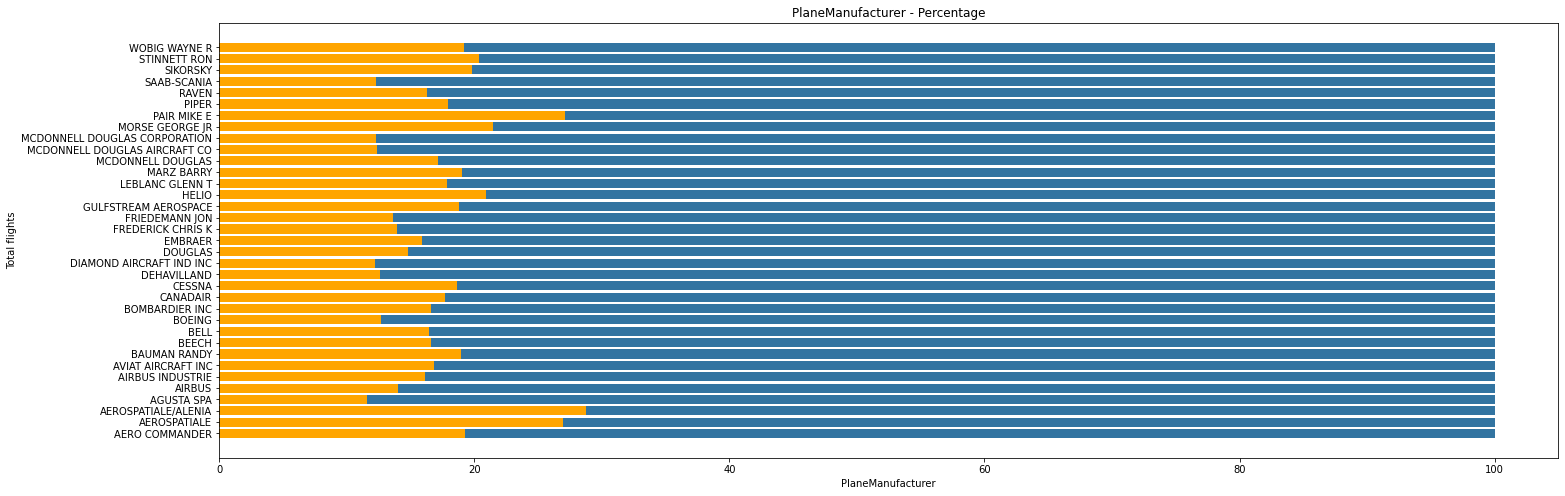

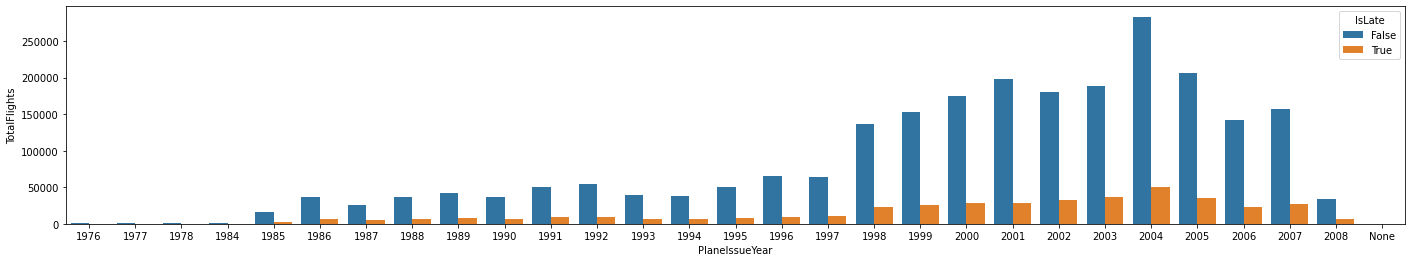

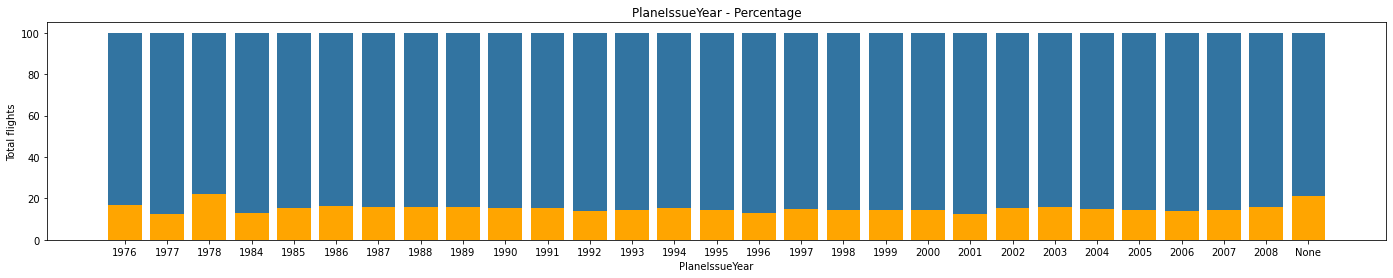

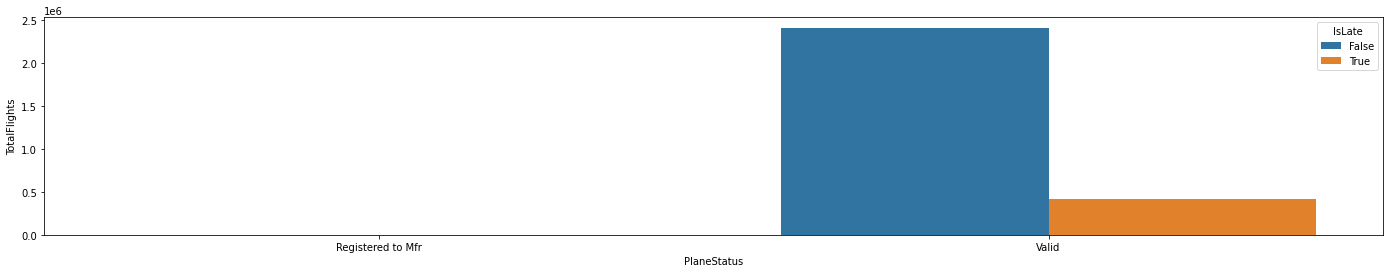

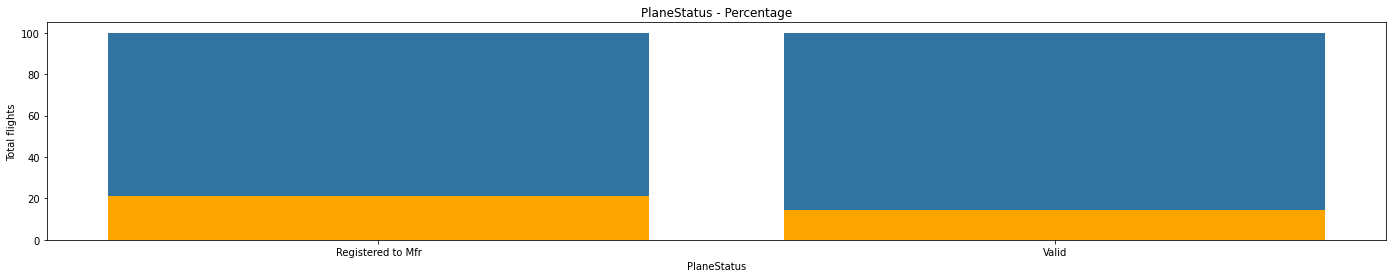

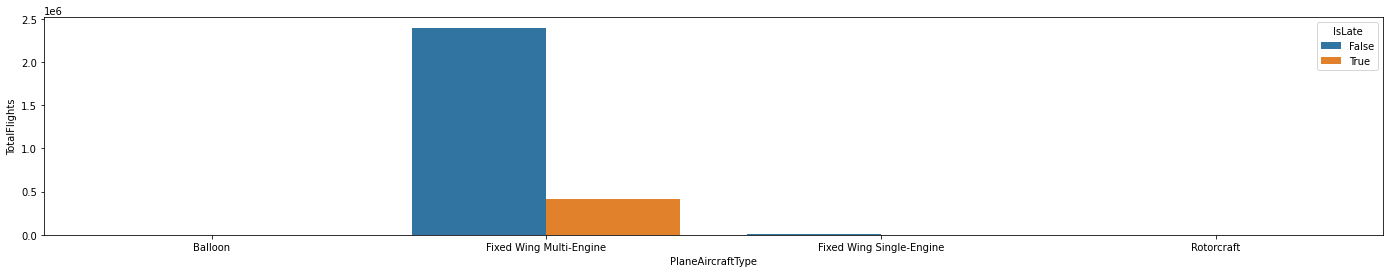

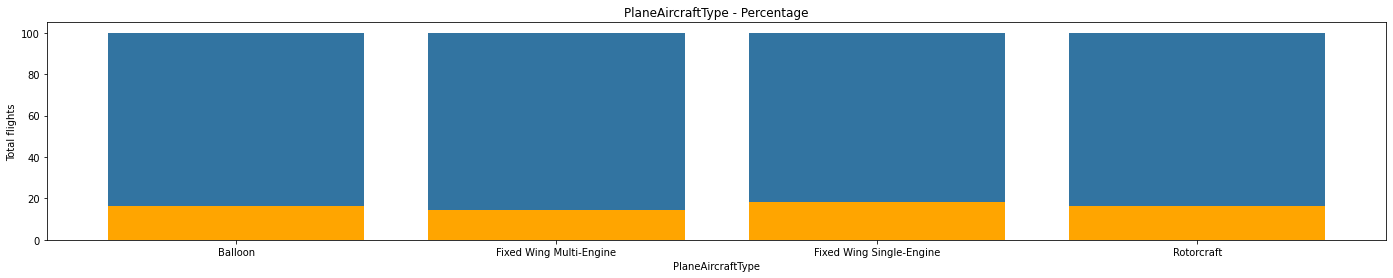

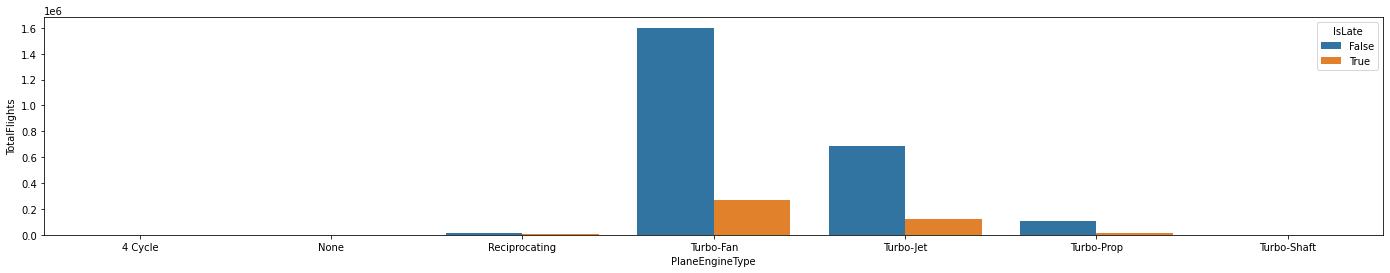

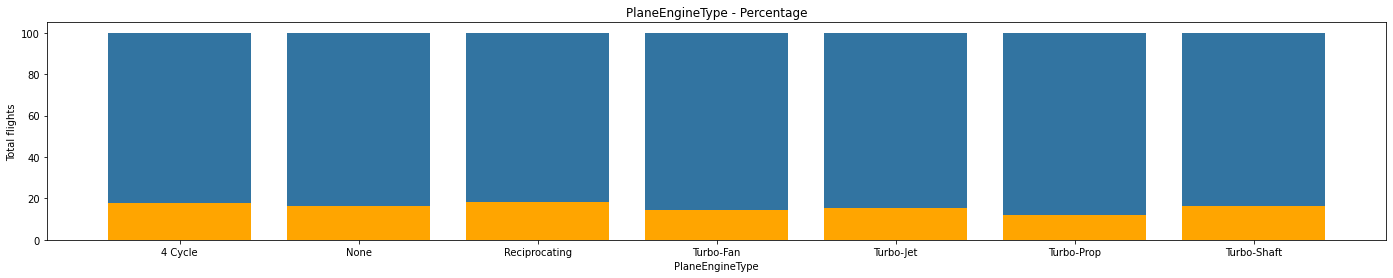

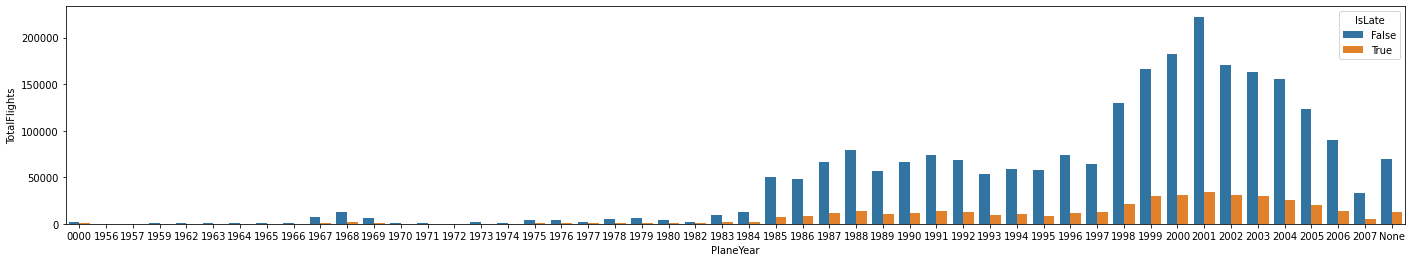

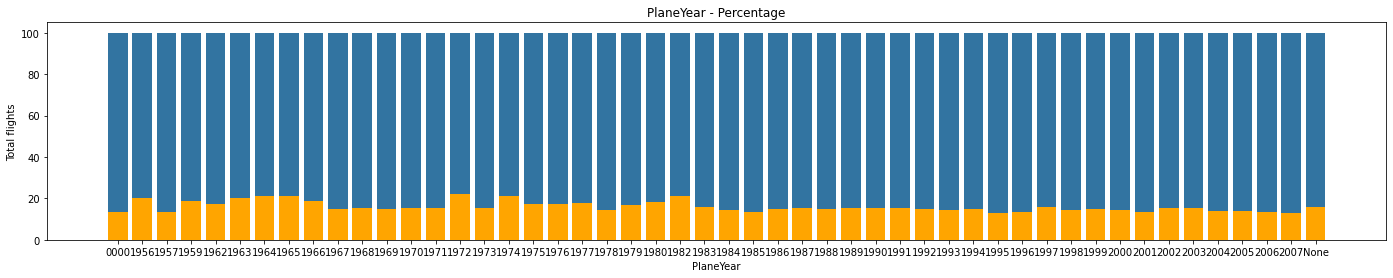

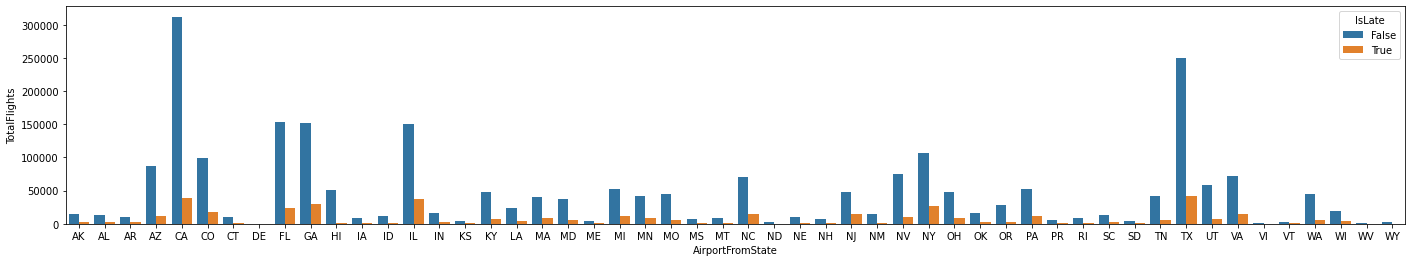

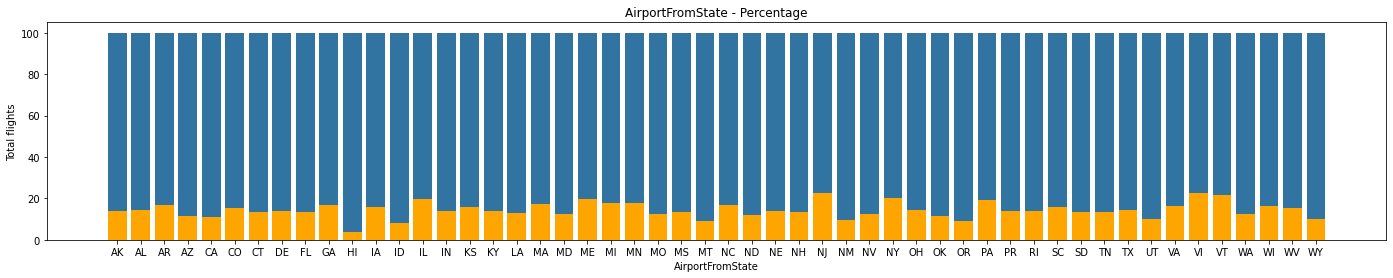

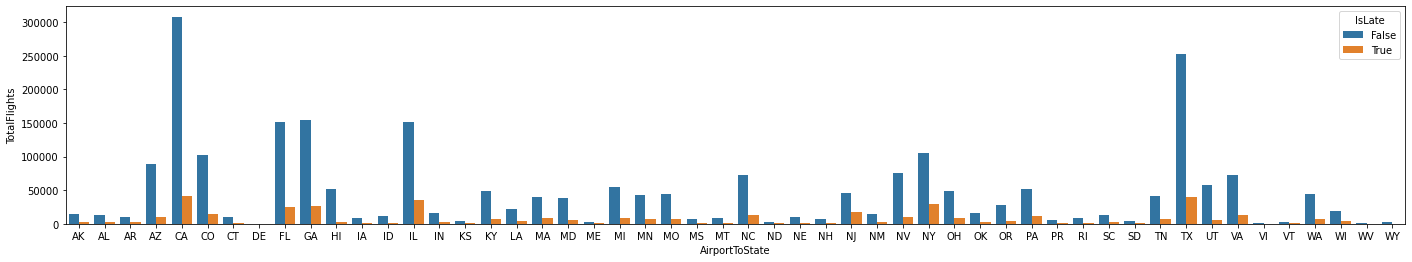

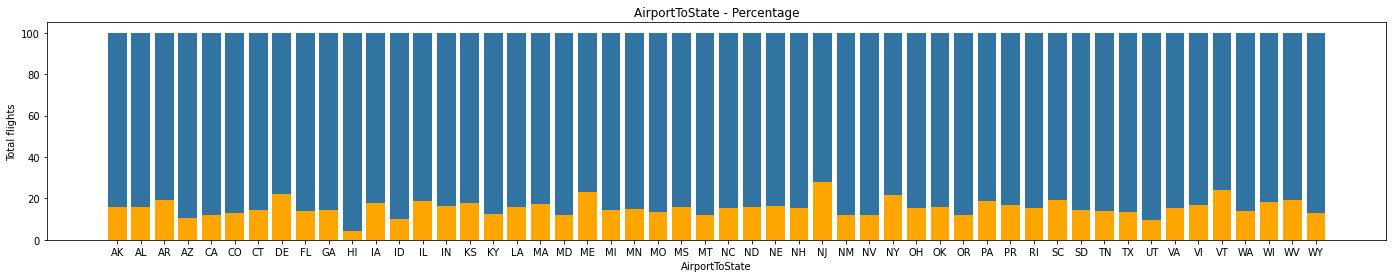

In [20]:
categorical_features = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime_Hour",
    "CRSArrTime_Hour",
    "CarrierDescription",
    "PlaneType",
    "PlaneModel",
    "PlaneManufacturer",
    "PlaneIssueYear",
    "PlaneStatus",
    "PlaneAircraftType",
    "PlaneEngineType",
    "PlaneYear",
    "AirportFromState",
    "AirportToState",
]
barh_columns = [
    "PlaneModel",
    "PlaneManufacturer",
    "CarrierDescription"
]

for column in categorical_features:
    visualize, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column)
    
    display(HTML(f"<h4>{column}</h4>"))

    # show IsLate percentage
    
    
    if column in barh_columns:
        height = 8 if column != "PlaneModel" else 28
        
        plt.figure(figsize=(24, height))
        sns.barplot(x="TotalFlights", hue="IsLate", y=column, data=visualize);
        plt.show()
        
        plt.figure(figsize=(24, height))
        plt.barh(column_values, is_late_percentage, color="orange")
        plt.barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    else:
        plt.figure(figsize=(24, 4))
        sns.barplot(x=column, hue="IsLate", y="TotalFlights", data=visualize);
        plt.show()
    
        plt.figure(figsize=(24, 4))
        plt.bar(column_values, is_late_percentage, color="orange")
        plt.bar(column_values, is_not_late_percentage, bottom=is_late_percentage, color="#3274a1")
        
    plt.xlabel(column)
    plt.ylabel("Total flights")
    plt.title(f"{column} - Percentage")
    plt.show()

From the visualized data, we can see that PlaneModel, DayofMonth, CRSDepTime_Hour, CRSArrTime_Hour, Month (4 months), CarrierDescription, PlaneManufacturer, AirportFromState, AirportToState have significant impact to the lateness of Flights.

In contrast, DayOfWeek, PlaneType, PlaneIssueYear, PlaneStatus, AircraftType don't show any promising influence to the lateness

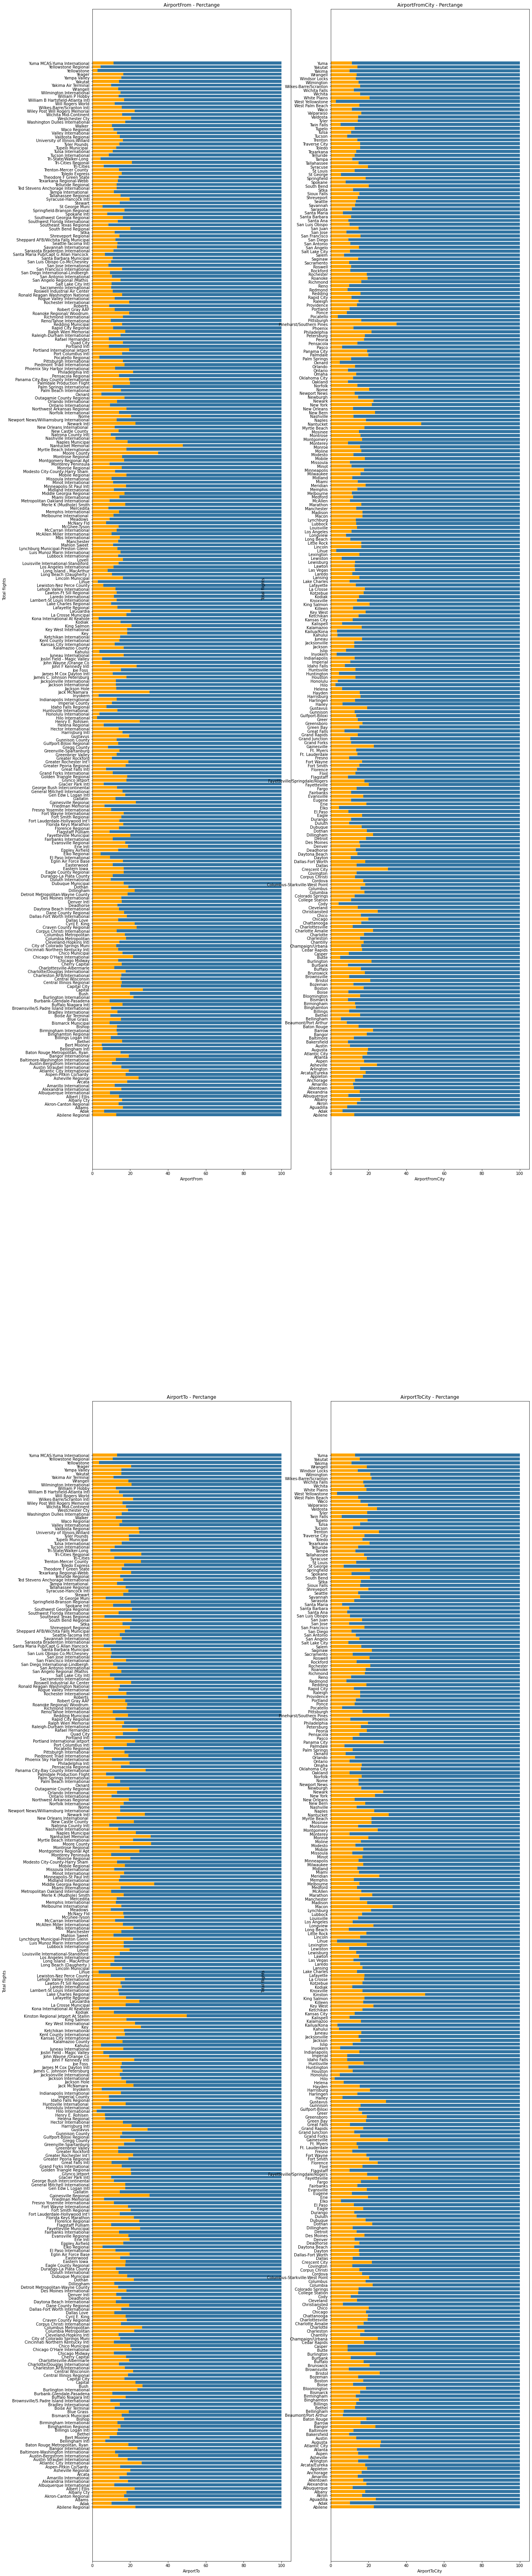

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(20, 120))
columns = [["AirportFrom", "AirportFromCity"], ["AirportTo", "AirportToCity"]]

for index, (column1, column2) in enumerate(columns):
    _, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column1)

    ax[index][0].barh(column_values, is_late_percentage, color="orange")
    ax[index][0].barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    ax[index][0].set_xlabel(column1)
    ax[index][0].set_ylabel("Total flights")
    ax[index][0].set_title(f"{column1} - Perctange")

    _, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column2)
    ax[index][1].barh(column_values, is_late_percentage, color="orange")
    ax[index][1].barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    ax[index][1].set_xlabel(column2)
    ax[index][1].set_ylabel("Total flights")
    ax[index][1].set_title(f"{column2} - Perctange")

plt.show()

<!--  "Origin", "Dest",  -->
Origin and dest also contribute to the lateness. Because there are bad and good conditioning airports, large and small area, easily for flights to depart and land, but it has so many unique values

### Hypothesis Testing

The null hypothesis for chi2 test is that "two categorical variables are independent". So a higher value of chi2 statistic means "two categorical variables are dependent" and MORE USEFUL for classification. [link](https://stackoverflow.com/a/51697444)

In [22]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [23]:
dropping_columns = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime_Hour",
    "CRSArrTime_Hour",
    "CarrierDescription",
    "PlaneType",
    "PlaneModel",
    "PlaneManufacturer",
    "PlaneIssueYear",
    "PlaneStatus",
    "PlaneAircraftType",
    "PlaneEngineType",
    "PlaneYear",
    "AirportFromState",
    "AirportToState",
    "PlaneModel",
    "PlaneManufacturer",
    "CarrierDescription",
    "AirportFrom",
    "AirportFromCity",
    "AirportTo",
    "AirportToCity"
]

for dropping_column in dropping_columns:
    table = df.groupby([dropping_column, "IsLate"]).size()
    table_values = table.values
    removed_indices = []
    
    for index, (key, values) in enumerate(table.items()):
        if (index == 0 and table.keys()[index + 1][0] != key[0]) or \
           (table.keys()[index - 1][0] != key[0] and table.keys()[index + 1][0] != key[0]) or \
           (index == len(table_values) - 1 and table.keys()[index - 1][0] != key[0]):
            removed_indices.append(index)

    for index in sorted(removed_indices, reverse=True):
        table_values = np.delete(table_values, index)

    table_len = len(table_values)
    table_values = table_values.reshape((table_len // 2, 2))
    stat, p, dof, expected = chi2_contingency(table_values)
    # show 31 days in every month to check when the demands increase
    # show the lateness also
    # stats.chi2.ppf(df.groupby(["DayofMonth", "IsLate"]).size().values.reshape((31, 2)))
    prob = 0.95
    critical = chi2.ppf(prob, dof)

    if abs(stat) >= critical:
        print(f"{dropping_column}: Dependent (reject H0)")
    else:
        print(f"{dropping_column}: Independent (fail to reject H0)")

Month: Dependent (reject H0)
DayofMonth: Dependent (reject H0)
DayOfWeek: Dependent (reject H0)
CRSDepTime_Hour: Dependent (reject H0)
CRSArrTime_Hour: Dependent (reject H0)
CarrierDescription: Dependent (reject H0)
PlaneType: Dependent (reject H0)
PlaneModel: Dependent (reject H0)
PlaneManufacturer: Dependent (reject H0)
PlaneIssueYear: Dependent (reject H0)
PlaneStatus: Dependent (reject H0)
PlaneAircraftType: Dependent (reject H0)
PlaneEngineType: Dependent (reject H0)
PlaneYear: Dependent (reject H0)
AirportFromState: Dependent (reject H0)
AirportToState: Dependent (reject H0)
PlaneModel: Dependent (reject H0)
PlaneManufacturer: Dependent (reject H0)
CarrierDescription: Dependent (reject H0)
AirportFrom: Dependent (reject H0)
AirportFromCity: Dependent (reject H0)
AirportTo: Dependent (reject H0)
AirportToCity: Dependent (reject H0)


Almost all of the features reject H0, which are clearly that the labels depended on them

### Filter noise & Feature engineering

In [24]:
from scipy import stats

df = df.drop([
    # Independent columns
    "PlaneStatus",
    
    # Correlated column but having lower correlation coefficient
    "CRSElapsedTime",

    # These below features have so many unique values
    "FlightNum",
    "AirportFrom",
    "AirportFromCity",
    "AirportTo",
    "AirportToCity",
    "PlaneModel",
    
    # PlaneYear and PlaneIssueYear also have plenty values whcih doesn't show a significant difference
    "PlaneYear",
    "PlaneIssueYear",
], axis=1)

numerical_features.remove("CRSElapsedTime")

# Q1,Q3 = np.percentile(sorted(df['Price']),[25,75])
# IQR = Q3 - Q1
# upperlim = Q3 + 1.5*IQR
# lowerlim = max(Q1 - 1.5*IQR,0)

# calculate z-score to filter noise
for feature in numerical_features:
    z_scores = np.abs(stats.zscore(df[feature]))
    df = df[z_scores <= 3]

In [25]:
dummy_columns = [
    "DayofMonth",
    "DayOfWeek",
    "PlaneType",
    "PlaneAircraftType",
    "PlaneEngineType",
    "CarrierDescription",
    "PlaneManufacturer",
    "AirportFromState",
    "AirportToState",
]

for column in dummy_columns:
    df = df.join(pd.get_dummies(df[column], column, drop_first=True, dtype=bool))
    
df = df.drop(dummy_columns, axis=1)

In [26]:
# feature engineering
# I see the abnormal from these hours and months, so I decided to create the new features for them
# calculate IG of CRSElapsedTime and Distance
df["IsArrTimeNoonOrEvening"] = df["CRSArrTime_Hour"].isin([str(i) for i in range(13, 24)])
df["IsUnusualCRSDepHour"] = df["CRSDepTime_Hour"].isin(["16", "17", "18", "19", "20", "21", "22", "23", "00", "01", "02", "03"])
df["IsSummerOrWinter"] = df["Month"].isin(["12", "01", "02", "06", "07", "08"])

df = df.drop(["CRSArrTime_Hour", "CRSDepTime_Hour", "Month"], axis=1)

In [27]:
df.head(5)

,Distance,TaxiIn,TaxiOut,AirportFromLat,AirportFromLong,AirportToLat,AirportToLong,IsLate,DayofMonth_02,DayofMonth_03,...,AirportToState_UT,AirportToState_VA,AirportToState_VT,AirportToState_WA,AirportToState_WI,AirportToState_WV,AirportToState_WY,IsArrTimeNoonOrEvening,IsUnusualCRSDepHour,IsSummerOrWinter
572249,1745,10,9,41.979595,-87.904464,33.942536,-118.408074,False,False,False,...,False,False,False,False,False,False,False,True,True,True
4019566,694,7,11,39.297605,-94.713906,41.410894,-81.849397,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4160076,529,7,35,35.214011,-80.943126,40.692497,-74.168661,False,False,False,...,False,False,False,False,False,False,False,True,True,False
4018162,304,15,10,38.174389,-85.736000,41.410894,-81.849397,False,False,False,...,False,False,False,False,False,False,False,True,True,True
3969071,1012,3,21,41.979595,-87.904464,27.975472,-82.533250,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [28]:
from sklearn.model_selection import train_test_split

X = df.drop(["IsLate"], axis=1)
y = df["IsLate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# because the below features don't illustrate the bell shape --> use min_max_scaling
min_max_scaling_columns = numerical_features

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train[min_max_scaling_columns])

X_train[min_max_scaling_columns] = min_max_scaler.transform(X_train[min_max_scaling_columns])
X_test[min_max_scaling_columns] = min_max_scaler.transform(X_test[min_max_scaling_columns])

In [29]:
del df, X, y

### Train models

#### ROC curve
__Definition:__ a graph showing the performance of a classification model at all classification thresholds. Plot two params:
- True Positive Rate: $ TPR = \frac{TP}{TP + FN} $ (denominator is positivity **True Positive** -> **Positive**, mẫu số là tổng số dương tính)
- False Positive Rate: $ FPR = \frac{FP}{FP + TN} $ (denominator is negativity, **False Positive** -> **Negative**, mẫu số là tổng số âm tính)

__Reference:__ https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

This graph doesn't show any promising result when classifying late or not late flights.

In [30]:
def show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test,  y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"data 1, auc={auc}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=4)
    plt.show()
    
    P = metrics.precision_score(y_test, y_pred)
    R = metrics.recall_score(y_test, y_pred)
    F = 2 * ((P * R) / (P + R))
    print("Precision:", P)
    print("Recall:", R)
    print("F1 score:", F)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn import metrics
import time

In [32]:
training_columns = X_train.columns

In [36]:
def train_n_visualize_model(modelClass, X_train, y_train, X_test, y_test):
    start = time.time()

    model = modelClass()
    model.fit(X_train, y_train);

    print("Total time to train model:", time.time() - start)

    test_score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test).max(axis=1)

    print("Test score:", test_score)
    print("Precision matrix:")
    print(classification_report(y_test, y_pred, target_names=["class 0", "class 1"]))
    
    show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob)
    
    importances = None
    
    if isinstance(model, LogisticRegression):
        if type(X_train) != np.ndarray:
            importances = pd.DataFrame({"Column": training_columns, "Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
        else:
            total_features = X_train.shape[1]

            importances = pd.DataFrame({"Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
    
    return model, y_pred_prob, importances

Due to the extremely imbalanced dataset, we can't use accuracy as a suitable score.

Rather, we use __recall__ because it's more appropriate in this situtation, because it actually measures rate of the predicted late flights among the ground-truth late flights.

#### Logistic Regression

Total time to train model: 59.479816198349
Test score: 0.8701190844416951
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      0.99      0.93    561305
     class 1       0.59      0.05      0.09     85295

    accuracy                           0.87    646600
   macro avg       0.73      0.52      0.51    646600
weighted avg       0.84      0.87      0.82    646600



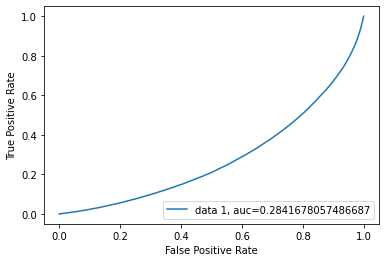

Precision: 0.5927442123094298
Recall: 0.049229145905387184
F1 score: 0.09090810682081425


,Column,Amount
2,TaxiOut,2.989468
181,AirportToState_NJ,0.893063
3,AirportFromLat,0.816767
201,IsArrTimeNoonOrEvening,0.695985
1,TaxiIn,0.675468
...,...,...
140,AirportFromState_OR,-0.691364
150,AirportFromState_WA,-0.786100
48,PlaneAircraftType_Fixed Wing Single-Engine,-0.820260
103,PlaneManufacturer_SAAB-SCANIA,-0.842109


In [34]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train, y_train, X_test, y_test)
importances

As we can see, LogisticRegression performs not so well in this dataset. I guess because the dataset doesn't have linear trending features to feed to the model.

In [35]:
del model1, _

#### Decision Tree

Total time to train model: 114.46538400650024
Test score: 0.8067506959480358
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.89      0.89    561305
     class 1       0.28      0.29      0.28     85295

    accuracy                           0.81    646600
   macro avg       0.58      0.59      0.59    646600
weighted avg       0.81      0.81      0.81    646600



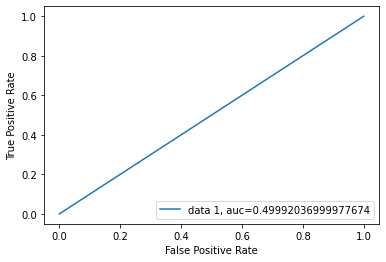

Precision: 0.2779146600963154
Recall: 0.29093147312269185
F1 score: 0.2842741358077727


In [36]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train, y_train, X_test, y_test)
importances

The recall is higher, we could predict 24% of late flight correctly

In [37]:
del model2, _

#### Naive Bayes

Total time to train model: 19.745211601257324
Test score: 0.7370909372100216
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.80      0.84    561305
     class 1       0.21      0.35      0.26     85295

    accuracy                           0.74    646600
   macro avg       0.55      0.57      0.55    646600
weighted avg       0.80      0.74      0.76    646600



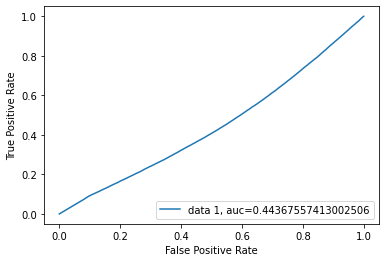

Precision: 0.20683639988370645
Recall: 0.3503136174453368
F1 score: 0.26010088920032903


In [38]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train, y_train, X_test, y_test)
importances

In [39]:
del model3, _

#### Support Vector Machine

In [40]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 621.5375437736511
Test score: 0.8730946489328797
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.99      0.93    561305
     class 1       0.61      0.11      0.18     85295

    accuracy                           0.87    646600
   macro avg       0.74      0.55      0.56    646600
weighted avg       0.84      0.87      0.83    646600



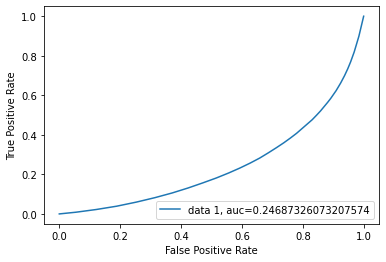

Precision: 0.6065552191654601
Recall: 0.10804853742892315
F1 score: 0.18342306123058244


In [41]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train, y_train, X_test, y_test)
importances

In [42]:
del model5, _

## PCA

In [33]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)

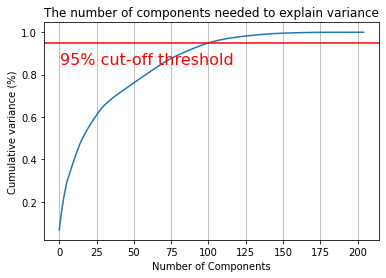

In [34]:
fig, ax = plt.subplots()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel("Number of Components")
plt.ylabel("Cumulative variance (%)")
plt.title("The number of components needed to explain variance")

plt.axhline(y=0.95, color='r', linestyle="-")
plt.text(0.5, 0.85, "95% cut-off threshold", color="red", fontsize=16)
ax.grid(axis="x")
plt.show()

In [35]:
pca = PCA(n_components=100).fit(X_train)

In [36]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#### Logistic Regression

Total time to train model: 8.12537145614624
Test score: 0.8689272304611203
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93    560555
     class 1       0.58      0.04      0.07     85567

    accuracy                           0.87    646122
   macro avg       0.73      0.52      0.50    646122
weighted avg       0.83      0.87      0.82    646122



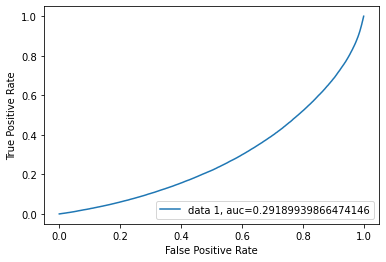

Precision: 0.5831124574024991
Recall: 0.03599518505966085
F1 score: 0.06780481898534932


,Amount
83,1.372730
99,1.263596
96,1.252966
77,0.582447
89,0.558538
...,...
67,-0.478060
92,-0.485003
94,-0.515689
2,-0.894185


In [37]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train_pca, y_train, X_test_pca, y_test)
importances

In [38]:
del model1, _

#### Decision Tree

Total time to train model: 799.7248513698578
Test score: 0.7978462271831016
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.88      0.88    560555
     class 1       0.26      0.29      0.27     85567

    accuracy                           0.80    646122
   macro avg       0.58      0.58      0.58    646122
weighted avg       0.81      0.80      0.80    646122



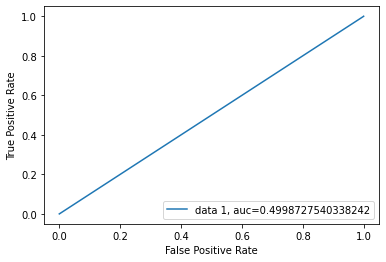

Precision: 0.2615723343671603
Recall: 0.28879123961340236
F1 score: 0.2745087148268699


In [39]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train_pca, y_train, X_test_pca, y_test)
importances

All of the scores decrease slightly when using PCA, around 0.00x

In [40]:
del model2, _

#### Naive Bayes

Total time to train model: 2.118971586227417
Test score: 0.8093827481497302
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.90      0.89    560555
     class 1       0.26      0.24      0.25     85567

    accuracy                           0.81    646122
   macro avg       0.57      0.57      0.57    646122
weighted avg       0.80      0.81      0.81    646122



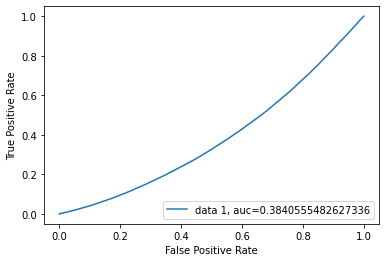

Precision: 0.26359211701231244
Recall: 0.2449425596316337
F1 score: 0.25392536951780953


In [41]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train_pca, y_train, X_test_pca, y_test)
importances

Naive Bayes significantly decreases the recall score of late flight and increase not-late flight's recall

In [42]:
del model3, _

#### Support Vector Machine

In [43]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 4136.360565900803
Test score: 0.8720628611933969
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.99      0.93    560555
     class 1       0.61      0.10      0.17     85567

    accuracy                           0.87    646122
   macro avg       0.74      0.54      0.55    646122
weighted avg       0.84      0.87      0.83    646122



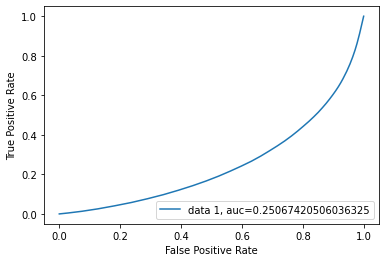

Precision: 0.6067804088836594
Recall: 0.0964273610153447
F1 score: 0.1664095194877225


In [44]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train_pca, y_train, X_test_pca, y_test)
importances

In [45]:
del model5, _

## SelectKBest

In [34]:
from sklearn.feature_selection import SelectKBest

selectKBest = SelectKBest(k=20)
selectKBest.fit(X_train, y_train)
X_train_kbest = selectKBest.transform(X_train)
X_test_kbest = selectKBest.transform(X_test)

print("New shape after transforming: ", X_train_kbest.shape)

New shape after transforming:  (1939878, 20)


#### Logistic Regression

Total time to train model: 3.330634117126465
Test score: 0.8685407020441491
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93    560785
     class 1       0.57      0.04      0.07     85841

    accuracy                           0.87    646626
   macro avg       0.72      0.52      0.50    646626
weighted avg       0.83      0.87      0.82    646626



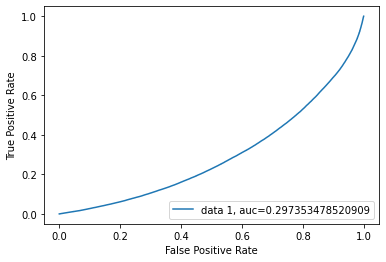

Precision: 0.5746162084969654
Recall: 0.0374995631458161
F1 score: 0.07040451428758898


,Amount
1,2.772203
0,0.704518
17,0.682714
15,0.555851
7,0.531224
18,0.493457
19,0.433363
13,0.315545
16,0.225372
5,0.196732


In [37]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train_kbest, y_train, X_test_kbest, y_test)
importances

In [38]:
del model1, _

#### Decision Tree

Total time to train model: 14.72642469406128
Test score: 0.8024917030864828
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.89      0.89    560785
     class 1       0.24      0.22      0.23     85841

    accuracy                           0.80    646626
   macro avg       0.56      0.56      0.56    646626
weighted avg       0.80      0.80      0.80    646626



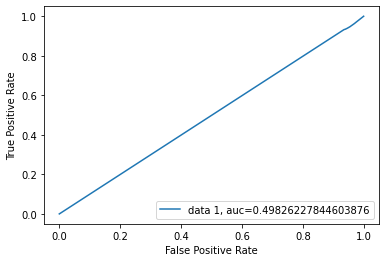

Precision: 0.239553659173747
Recall: 0.22433336051537145
F1 score: 0.23169381812931636


In [39]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train_kbest, y_train, X_test_kbest, y_test)
importances

All of the scores decrease slightly when using PCA, around 0.00x

In [40]:
del model2, _

#### Naive Bayes

Total time to train model: 1.0744051933288574
Test score: 0.7885779414994138
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.86      0.88    560785
     class 1       0.25      0.30      0.27     85841

    accuracy                           0.79    646626
   macro avg       0.57      0.58      0.57    646626
weighted avg       0.80      0.79      0.80    646626



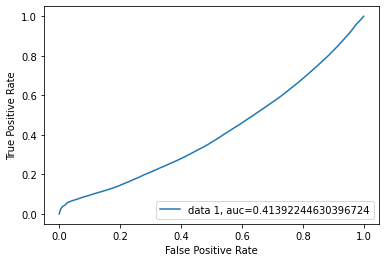

Precision: 0.24989675313182166
Recall: 0.2960589927889936
F1 score: 0.27102629319768157


In [41]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train_kbest, y_train, X_test_kbest, y_test)
importances

Naive Bayes significantly decreases the recall score of late flight and increase not-late flight's recall

In [42]:
del model3, _

#### Support Vector Machine

In [43]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 239.65579867362976
Test score: 0.8461119719899911
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.95      0.91    560785
     class 1       0.32      0.14      0.20     85841

    accuracy                           0.85    646626
   macro avg       0.60      0.55      0.56    646626
weighted avg       0.81      0.85      0.82    646626



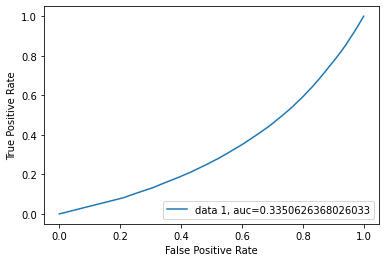

Precision: 0.32171462861019073
Recall: 0.14364930511061147
F1 score: 0.1986148022871869


In [44]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train_kbest, y_train, X_test_kbest, y_test)
importances

In [45]:
del model5, _

## RFE

In [46]:
from sklearn.feature_selection import RFE

In [47]:
def train_n_visualize_model_with_rfe(estimator, X_train, y_train, X_test, y_test, n_features_to_select=10, step=1):
    start = time.time()

    model = RFE(estimator, n_features_to_select=10, step=1)
    model.fit(X_train, y_train);

    print("Total time to train model:", time.time() - start)

    test_score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test).max(axis=1)

    print("Test score:", test_score)
    print("Precision matrix:")
    print(classification_report(y_test, y_pred, target_names=["class 0", "class 1"]))
    
    show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob)
    
    importances = None
    
    if isinstance(model, LogisticRegression):
        if type(X_train) != np.ndarray:
            importances = pd.DataFrame({"Column": training_columns, "Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
        else:
            total_features = X_train.shape[1]

            importances = pd.DataFrame({"Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
    
    return model, y_pred_prob, importances

### Decision Tree

Total time to train model: 140.06409621238708
Test score: 0.8122856179615419
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.91      0.89    560785
     class 1       0.24      0.20      0.22     85841

    accuracy                           0.81    646626
   macro avg       0.56      0.55      0.56    646626
weighted avg       0.80      0.81      0.80    646626



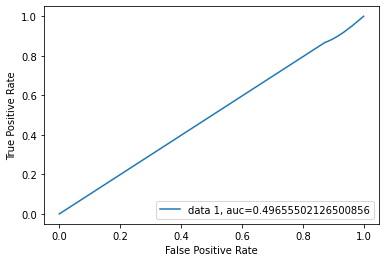

Precision: 0.24326003409714797
Recall: 0.19614170384781165
F1 score: 0.2171745509657863


In [48]:
model1, _, importances = train_n_visualize_model_with_rfe(DecisionTreeClassifier(), X_train_kbest, y_train, X_test_kbest, y_test)
importances

In [49]:
del model1, _

# Summary
- Dimensionality reduction methods:
    - NaiveBayes and RandomForest perform ineffectively when having many features. When not applying RFE or PCA, the performance is low compared to when applying them.
    - They don't positively impact other algorithms like DecisionTree and LogisticRegression. In several case they could reduce the performance.
- I can't train SVM because it takes so long to finish (even longer than RandomForest)
- I can't show the the Residual and Homoscedasticity plots because this is a binary classification problem.
- This problem doesn't have any particular features strongly affect the label. It's quite understandable because if we can build high confidence model, it could innovate the flight lateness problem.
- Recall is the most effective factor here to evaluate the model because it predicts a recall rate per each label. It is important to correctly increase the rate of predicted late flights and actual late flights (recall).